# Financial News Sentiment Analysis

## Method

Train NLP Model on financial data using several methods:  
https://blog.csdn.net/fengdu78/article/details/109475539    
https://github.com/yuki678/financial-phrase-bert/blob/master/SA_Model_Comparison_Finphrase.ipynb  

A. Lexicon-based approach   
B. Tfidf  
C1. RNN  
C2. RNN with Chinese pre-trained word embedding  
D. Bert (pre-trained, hugging-face impementation)  

In [5]:
# imported functions from Pycharm .py are updated automatically
%load_ext autoreload
%autoreload 2

In [ ]:
%reload_ext autoreload

In [1]:
# can use GPU in google collab
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
import re
import numpy as np
np.set_printoptions(precision=3)
import pandas as pd
import itertools
from collections import Counter
from tqdm import tqdm
import tarfile

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import jieba
from gensim.utils import simple_preprocess
import nltk
# nltk.download('words')
from nltk.corpus import words
import torch

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

## Data
Data source: https://www.datafountain.cn/competitions/353/datasets  
金融领域新闻，每个样本标记了实体列表以及负面实体列表。任务是判断一个样本是否是负面以及对应的负面的实体。  
Financial news: each sample tags the entities and key entities.  
Task: predict whether the text contains negative information.  
Form: Financial network text (title and content) and entities that appear in the text.  
Volume: The training set has 10,000 data and the test set has 10,000 data.  
Type: Chinese Natural Language Text.  

All training data are given in CSV format. Each data includes ID, title, text, entity, negative and key entity.  

|Field Info	| Type | Description  |
|---|---|---|
|id	| String	| Data ID | 
|title	| String |	 Text title | 
|text	| String	| Text content | 
|entity	| String	| Given entities | 
|negative	| String	| Does the text contain negative information:<br />The value of “negative” is 0 or 1. <br /> 1 stands for negative, and 0 for non-negative.  |
|key_entity	| String	| Key entity that is negative in the news|

The test data is also in CSV format, with each data including id, title, text and entity.  

In [8]:
train_data = pd.read_csv("Train_Data.csv", encoding="utf-8",              
                         dtype={'id': 'str',
                             'title': 'str',
                             'text': 'str',
                             'entity': 'str',
                             'negative': 'int8',
                             'key_entity': 'str'})
# test_data = pd.read_csv("Test_Data.csv", encoding='utf-8')

In [16]:
train_data.text[0]

'????发表了博文《【富金利】9月富金利教你如何安全提高最大化收益！》网络理财时代参与互联网投资理财选择正规的理财平台是理财关键，很多人都因为没有经受住高收益的诱惑不进行理性投资而遭遇了欺骗，微弱，而对网上投资理【富金利】9月富金利教你如何安全提高最大化收益！ ?????'

In [9]:
# preprocess: 
for i, news in tqdm(train_data.iterrows(), total=len(train_data)):
    train_data.loc[i, "text"] = re.sub("\W+|http\S+", "", news.text)

100%|██████████| 4999/4999 [00:03<00:00, 1323.65it/s]


In [10]:
train_data.set_index("id", inplace=True)

In [ ]:
train_data

,title,text,entity,negative,key_entity
id,,,,,
83dcefb7,????发表了博文《【富金利】9月富金利教你如何安全提高最大化收益！》网络理财时代参与互联网...,发表了博文富金利9月富金利教你如何安全提高最大化收益网络理财时代参与互联网投资理财选择正规的...,理财时代;富金利,0,NaN
1ad5be0d,#小资钱包涉嫌诈骗[超话]##小资钱包[超话]##迫切急待回归活命钱##头号直通中纪委[超话...,小资钱包涉嫌诈骗超话小资钱包超话迫切急待回归活命钱头号直通中纪委超话中纪委监察部超话聚焦海淀...,小资钱包;恒丰银行,1,小资钱包;恒丰银行
6dd28e9b,?????扫黑除恶 诈骗犯齐聚海淀，保护伞根深蒂固，黑社会嚣张跋扈，出借人走投无路！ 尊敬的...,扫黑除恶诈骗犯齐聚海淀保护伞根深蒂固黑社会嚣张跋扈出借人走投无路尊敬的中央扫黑除恶第11督导...,国有投资;资易贷（北京）金融信息服务有限公司;小资钱包;资易贷,1,资易贷（北京）金融信息服务有限公司;小资钱包
1db87a14,平安银行车主贷?????? 1??期限长至48期?? 2??滴滴司机可做?? 3??白户逾期...,平安银行车主贷1期限长至48期2滴滴司机可做3白户逾期可做4不打家人电话5不装定位GPS6额...,平安银行;车主贷;平安银行车主贷,0,NaN
fa005713,NaN,旺旺贷跑路深圳警方确定投资人被骗,旺贷;旺旺贷,1,旺旺贷
...,...,...,...,...,...
418e6a12,中国平安(平安普惠)客服经理林东某它妈的真烂，卧藏在平安普惠这种藏污纳垢之所，专搞诈骗营生，...,中国平安平安普惠客服经理林东某它妈的真烂卧藏在平安普惠这种藏污纳垢之所专搞诈骗营生就像混在羊...,及时雨贷;平安普惠;中国平安,1,平安普惠
a8edcf27,NaN,nbspnbspnbspnbspnbsp以钱宝网事件为例以项目年化收益率高达50以上吸引投资...,钱宝,1,钱宝
dfeaffb1,NaN,179雀尚枝头71号提现困难资金链断了现在每月返6没有跑路,资金链;雀尚枝头+7.1号,1,雀尚枝头+7.1号


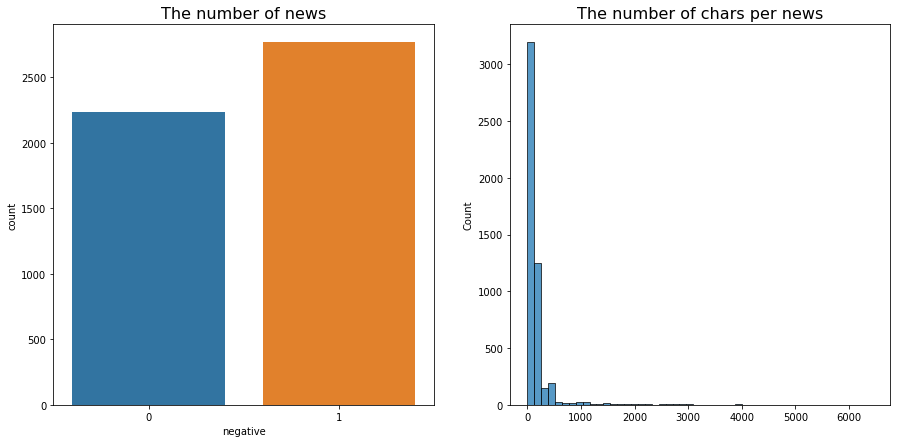

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

sns.countplot(x='negative', data=train_data, ax=ax1)
ax1.set_title('The number of news', fontsize=16)
sns.histplot([len(words) for words in train_data['text']], bins=50, ax=ax2)
ax2.set_title('The number of chars per news', fontsize=16)

plt.show()

## A. Lexicon-based approach

### Dictionary
* LM dictionary (finance, English translated to Chinese, contains positive/negative lists of words)  
1）参照曾庆生等（2018）的研究，以Loughran and McDonald（2011）提供的金融情感英文词汇列表为基础，依据有道词典和金山词霸对LM 词典中的英文词汇进行了翻译，与曾庆生等（2018）保留一个英文词汇对应多个中文单词的情况不同，本数据库只保留与该英文词汇表达的中文情感最相关的中文词汇，最终的词汇列表包括 2080 个消极词，1076 个积极词。
由此计算 LM_TONE1=（积极词汇数-消极词汇数）/年报词汇数，同时我们还提供LM_TONE2=（积极词汇数-消极词汇数）/（积极词汇数+消极词汇数），LM_TONE 值越大，表示文本信息语气越积极。

* NTUSD (all Chinese, contains positive/negative lists of words)  
2）参照王华杰和王克敏（2018）的研究，使用台湾大学制作的《中文情感极性词典》，将诸如“积极”、“进步”、“高效”等积极属性词语集作为积极情绪词语列表；将诸如“低迷”、“暗淡”、“不利”等消极属性词语集作为消极情绪词语列表。
基于此，计算文本信息语气 NTUSD _TONE=（积极词汇数量-消极词汇数量） /（积极词汇数量+消极词汇数量），NTUSD_TONE 值越大，表示文本信息语气越积极。

创建中文词汇列表之后，采用分词包围Python开放源“结巴”中文分词模块对年报文本进行自动分词，然后进行词频统计。 

read dictionaries from excel and save to txt files

In [ ]:
dict_folder = "dictionary/"
LM_pos = pd.read_excel(dict_folder+"LM词典+NTUSD词典.xlsx", header=None, sheet_name=0)
LM_neg = pd.read_excel(dict_folder+"LM词典+NTUSD词典.xlsx", header=None, sheet_name=1)
NTUSD_pos = pd.read_excel(dict_folder+"LM词典+NTUSD词典.xlsx", header=None, sheet_name=2)
NTUSD_neg = pd.read_excel(dict_folder+"LM词典+NTUSD词典.xlsx", header=None, sheet_name=3)

In [ ]:
with open(dict_folder+"LM_positive.txt",'w',encoding='utf-8') as f:
    np.savetxt(f, LM_pos, fmt='%s', encoding='utf-8')
with open(dict_folder+"LM_negative.txt",'w',encoding='utf-8') as f:
    np.savetxt(f, LM_neg, fmt='%s', encoding='utf-8')
with open(dict_folder+"NTUSD_positive.txt",'w',encoding='utf-8') as f:
    np.savetxt(f, NTUSD_pos, fmt='%s', encoding='utf-8')
with open(dict_folder+"NTUSD_negative.txt",'w',encoding='utf-8') as f:
    np.savetxt(f, NTUSD_pos, fmt='%s', encoding='utf-8')

load dictionaries in order to segment Chinese sentences

In [ ]:
jieba.load_userdict(dict_folder+"LM_positive.txt")
jieba.load_userdict(dict_folder+"LM_negative.txt")
jieba.load_userdict(dict_folder+"NTUSD_positive.txt")
jieba.load_userdict(dict_folder+"NTUSD_negative.txt")

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\wangy\AppData\Local\Temp\jieba.cache
Loading model cost 0.706 seconds.
Prefix dict has been built successfully.


also load company names (entities)

In [ ]:
train_data.entity

0                              理财时代;富金利
1                             小资钱包;恒丰银行
2       国有投资;资易贷（北京）金融信息服务有限公司;小资钱包;资易贷
3                      平安银行;车主贷;平安银行车主贷
4                                旺贷;旺旺贷
                     ...               
4994                     及时雨贷;平安普惠;中国平安
4995                                 钱宝
4996                      资金链;雀尚枝头+7.1号
4997                           小资钱包;资易贷
4998                               华夏银行
Name: entity, Length: 4999, dtype: object

In [ ]:
entities = set()
for entity in train_data.entity.dropna().values:
    for word in entity.split(";"):
#         word = re.sub("[?| ]", "", word)
        if not word:
            continue
        entities.add(word)

In [ ]:
# Convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long.
entities = simple_preprocess(" ".join(entities))
entities = list(set(entities))

In [ ]:
with open(dict_folder+"entities.txt",'w',encoding='utf-8') as f:
    for item in entities:
        f.write("%s\n" % item)

In [ ]:
jieba.load_userdict(dict_folder+"entities.txt")

LM_TONE1=（积极词汇数-消极词汇数）/年报词汇数   
LM_TONE1 > 0: the text is positive  
LM_TONE2=（积极词汇数-消极词汇数）/（积极词汇数+消极词汇数）  
LM_TONE2 > 0: the text is positive  
NTUSD_TONE=（积极词汇数量-消极词汇数量）/（积极词汇数量+消极词汇数量）  
NTUSD_TONE > 0: the text is positive  

In [16]:
lexi_df = train_data.copy()  # save lexicon info

In [ ]:
# if text is nan, count is 0
lexi_df["entity_count"] = lexi_df["entity"].apply(lambda ent: len(ent.split(";")) if ent is str else 0)
lexi_df["key_entity_count"] = lexi_df["key_entity"].apply(lambda ent: len(ent.split(";")) if ent is str else 0)

In [ ]:
# 积极的词汇列表
LM_pos_list = LM_pos.values.T.tolist()[0]
NTUSD_pos_list = NTUSD_pos.values.T.tolist()[0]
# 消极的词汇列表
LM_neg_list = LM_neg.values.T.tolist()[0]
NTUSD_neg_list = NTUSD_neg.values.T.tolist()[0]

In [ ]:
def get_news_tone(corpus, LM_pos_list, LM_neg_list, NTUSD_pos_list, NTUSD_neg_list):
    wordcount = len(corpus)  # total word count: 词组
    if wordcount == 0:
        return [0] * 8
    corpus_counter = Counter(corpus)  # word: count
    
    LM_pos_set = set(corpus) & set(LM_pos_list)  # 积极词汇在年报中出现的词
    LM_neg_set = set(corpus) & set(LM_neg_list)
    # 积极词汇数量，消极词汇数量
    LM_pos_count = sum([v for k, v in corpus_counter.items() if k in LM_pos_set])
    LM_neg_count = sum([v for k, v in corpus_counter.items() if k in LM_neg_set])
    LM_tone1 = (LM_pos_count - LM_neg_count) / wordcount
    if LM_pos_count + LM_neg_count == 0:
        LM_tone2 = 0
    else:
        LM_tone2 = (LM_pos_count - LM_neg_count) / (LM_pos_count + LM_neg_count)
    
    NTUSD_pos_set = set(corpus) & set(NTUSD_pos_list)
    NTUSD_neg_set = set(corpus) & set(NTUSD_neg_list)
    # 积极词汇数量，消极词汇数量
    NTUSD_pos_count = sum([v for k, v in corpus_counter.items() if k in NTUSD_pos_set])
    NTUSD_neg_count = sum([v for k, v in corpus_counter.items() if k in NTUSD_neg_set])
    if NTUSD_pos_count + NTUSD_neg_count == 0:
        NTUSD_tone = 0
    else:
        NTUSD_tone = (NTUSD_pos_count - NTUSD_neg_count) / (NTUSD_pos_count + NTUSD_neg_count)
    
    stats = [wordcount, LM_pos_count, LM_neg_count, NTUSD_pos_count, NTUSD_neg_count,\
              round(LM_tone1,3), round(LM_tone2,3), round(NTUSD_tone,3)]
    return stats

### Tokenize Chinese
https://investigate.ai/text-analysis/how-to-make-scikit-learn-natural-language-processing-work-with-japanese-chinese/  
Chinese stopwords:  
https://github.com/stopwords-iso/stopwords-zh

In [ ]:
# a list of Chinese stopwords
chinese_stopwords = [k.strip() for k in open('dictionary/stopwords-zh.txt', 
                                             encoding='utf8').readlines() if k.strip() != '']

### Jieba tokenization: Python Chinese segmentation tool
https://github.com/fxsjy/jieba
1. 精确模式，试图将句子最精确地切开，适合文本分析；  
seg_list = jieba.cut("我来到北京清华大学", cut_all=False)  
print("Default Mode: " + "/ ".join(seg_list))  # 精确模式  
2. 全模式，把句子中所有的可以成词的词语都扫描出来, 速度非常快，但是不能解决歧义；  
seg_list = jieba.cut("我来到北京清华大学", cut_all=True)  
print("Full Mode: " + "/ ".join(seg_list))  # 全模式  
3. 搜索引擎模式，在精确模式的基础上，对长词再次切分，提高召回率，适合用于搜索引擎分词。  
seg_list = jieba.cut_for_search("小明硕士毕业于中国科学院计算所，后在日本京都大学深造")  # 搜索引擎模式  
print(", ".join(seg_list))  

In [ ]:
# Takes in a document, separates the words
def tokenize_zh(text):
    def filter_words(x):
        # if this english phrase is not an english word, delete it
        if x.isascii():  # English token
            if x in (words.words("en") + entities) and len(x) > 1:
                return True
        # if chinese token is a stopword, delete it
        else:  # Chinese token
            if x not in chinese_stopwords:
                return True
        return False
    
    tokens = jieba.lcut(text)  # Jieba tokenization
#     tokens = simple_preprocess(" ".join(tokens))
    tokenized = list(filter(filter_words, tokens))
    return tokenized

In [ ]:
stats_col = ["wordcount", "LM Positive", "LM Negative", "NTUSD Positive", "NTUSD Negative",\
                      "LM Tone1", "LM Tone2", "NTUSD Tone"]
tokens_df = pd.DataFrame(columns=["sent", "label"], index=lexi_df.index)
tokens_df["label"] = lexi_df["negative"]
tokens_df["wordcount"] = lexi_df["wordcount"]

for i, news in tqdm(lexi_df.iterrows(), total=len(lexi_df)):
    tokens = tokenize_zh(news.text)
    tokens_df.loc[i, "sent"] = " ".join(tokens)
    tone = get_news_tone(tokens, LM_pos_list, LM_neg_list, NTUSD_pos_list, NTUSD_neg_list)
    lexi_df.loc[i, stats_col] = tone

100%|██████████████████████████████████████████████████████████████████████████████| 4999/4999 [58:02<00:00,  1.44it/s]


In [ ]:
tokens_df.to_csv("data/tokens.csv.gz", compression="gzip")

In [ ]:
tokens_df = pd.read_csv("data/tokens.csv.gz", compression="gzip", index_col=0,                          
                        dtype={
                             'id': 'str',
                             'sent': 'str',
                             'label': int,
                             'wordcount': float})
tokens_df = tokens_df[(tokens_df.wordcount>0)]
tokens_df

,sent,label,wordcount
id,,,
83dcefb7,发表 博文 富金利 富金利 教 安全 提高 最大化 收益 网络 理财时代 参与 互联网 投资...,0,44.0
1ad5be0d,小资钱包 涉嫌 诈骗 超话 小资钱包 超话 迫切 急待 回归 活命钱 头号 直通 中纪委 超...,1,46.0
6dd28e9b,扫黑 除恶 诈骗犯 齐聚 海淀 保护伞 根深蒂固 黑社会 嚣张 跋扈 出借 走投无路 尊敬的...,1,40.0
1db87a14,平安银行车主贷 期限 长至 期 滴滴 司机 白户 逾期 家人 电话 不装 定位 额度 最高 万,0,15.0
fa005713,旺旺贷 跑 路 深圳 警方 确定 投资人 被骗,1,8.0
...,...,...,...
418e6a12,中国平安 平安普惠 客服 经理 林东 妈 真烂 卧藏 平安普惠 这种 藏污纳垢 专 搞 诈骗...,1,37.0
a8edcf27,钱宝网 事件 为例 项目 年化 收益率 高达 吸引 投资者 收益 构成 中拉 人头 推广 收...,1,40.0
dfeaffb1,雀尚枝头 号 提现 困难 资金链 断 现在 每月 返 没有 跑 路,1,12.0


In [ ]:
print("Text: ", train_data.text[0], "\n\nTokenized: ", tokens_df.sent[0])

Text:  发表了博文富金利9月富金利教你如何安全提高最大化收益网络理财时代参与互联网投资理财选择正规的理财平台是理财关键很多人都因为没有经受住高收益的诱惑不进行理性投资而遭遇了欺骗微弱而对网上投资理富金利9月富金利教你如何安全提高最大化收益 

Tokenized:  发表 博文 富金利 富金利 教 安全 提高 最大化 收益 网络 理财时代 参与 互联网 投资 理财 选择 正规的 理财 平台 理财 关键 很多 没有 经受 住 高 收益 诱惑 进行 理性 投资 遭遇 欺骗 微弱 网上 投资 理 富金利 富金利 教 安全 提高 最大化 收益


Generage wordcloud image  
https://fonts.google.com/specimen/Ma+Shan+Zheng?subset=chinese-simplified

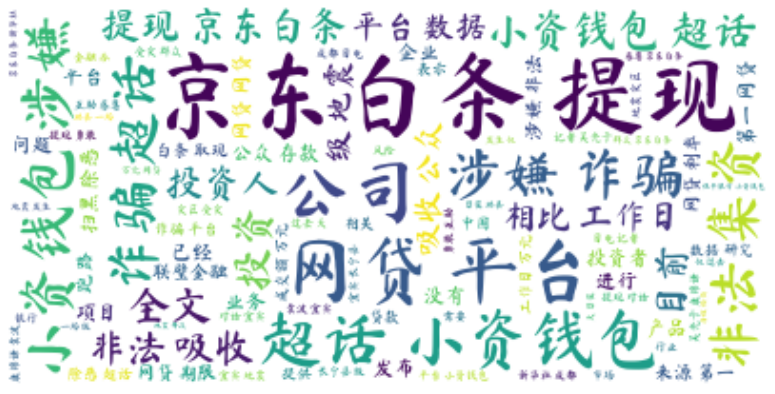

In [ ]:
text = tokens_df.sent.str.cat(sep=' ')  # combine all tokens

# Generate a word cloud image
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", 
                      font_path='MaShanZheng-Regular.ttf').generate(text)
plt.figure(figsize=(15,7))
# Display the generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Prediction by count
If the mean of tone predictions <= 0, negative text.

In [ ]:
lexi_df["pred_tone"] = lexi_df[["LM Tone1", "LM Tone2", "NTUSD Tone"]].mean(1) <= 0

In [ ]:
lexi_df.to_csv("data/news_tone.csv.gz", compression="gzip")

In [ ]:
lexi_df = pd.read_csv("data/news_tone.csv.gz", compression="gzip", index_col=0)

In [ ]:
lexi_df

,title,text,entity,negative,key_entity,entity_count,key_entity_count,wordcount,LM Positive,LM Negative,NTUSD Positive,NTUSD Negative,LM Tone1,LM Tone2,NTUSD Tone,pred_tone
id,,,,,,,,,,,,,,,,
83dcefb7,????发表了博文《【富金利】9月富金利教你如何安全提高最大化收益！》网络理财时代参与互联网...,发表了博文富金利9月富金利教你如何安全提高最大化收益网络理财时代参与互联网投资理财选择正规的...,理财时代;富金利,0,NaN,0,0,42.0,7.0,6.0,8.0,5.0,0.024,0.077,0.231,False
1ad5be0d,#小资钱包涉嫌诈骗[超话]##小资钱包[超话]##迫切急待回归活命钱##头号直通中纪委[超话...,小资钱包涉嫌诈骗超话小资钱包超话迫切急待回归活命钱头号直通中纪委超话中纪委监察部超话聚焦海淀...,小资钱包;恒丰银行,1,小资钱包;恒丰银行,0,0,45.0,0.0,3.0,1.0,2.0,-0.067,-1.000,-0.333,True
6dd28e9b,?????扫黑除恶 诈骗犯齐聚海淀，保护伞根深蒂固，黑社会嚣张跋扈，出借人走投无路！ 尊敬的...,扫黑除恶诈骗犯齐聚海淀保护伞根深蒂固黑社会嚣张跋扈出借人走投无路尊敬的中央扫黑除恶第11督导...,国有投资;资易贷（北京）金融信息服务有限公司;小资钱包;资易贷,1,资易贷（北京）金融信息服务有限公司;小资钱包,0,0,39.0,1.0,0.0,1.0,1.0,0.026,1.000,0.000,False
1db87a14,平安银行车主贷?????? 1??期限长至48期?? 2??滴滴司机可做?? 3??白户逾期...,平安银行车主贷1期限长至48期2滴滴司机可做3白户逾期可做4不打家人电话5不装定位GPS6额...,平安银行;车主贷;平安银行车主贷,0,NaN,0,0,14.0,1.0,0.0,1.0,0.0,0.071,1.000,1.000,False
fa005713,NaN,旺旺贷跑路深圳警方确定投资人被骗,旺贷;旺旺贷,1,旺旺贷,0,0,6.0,1.0,0.0,1.0,1.0,0.167,1.000,0.000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418e6a12,中国平安(平安普惠)客服经理林东某它妈的真烂，卧藏在平安普惠这种藏污纳垢之所，专搞诈骗营生，...,中国平安平安普惠客服经理林东某它妈的真烂卧藏在平安普惠这种藏污纳垢之所专搞诈骗营生就像混在羊...,及时雨贷;平安普惠;中国平安,1,平安普惠,0,0,29.0,0.0,3.0,1.0,4.0,-0.103,-1.000,-0.600,True
a8edcf27,NaN,nbspnbspnbspnbspnbsp以钱宝网事件为例以项目年化收益率高达50以上吸引投资...,钱宝,1,钱宝,0,0,37.0,7.0,2.0,1.0,1.0,0.135,0.556,0.000,False
dfeaffb1,NaN,179雀尚枝头71号提现困难资金链断了现在每月返6没有跑路,资金链;雀尚枝头+7.1号,1,雀尚枝头+7.1号,0,0,7.0,0.0,2.0,0.0,2.0,-0.286,-1.000,-1.000,True


### Prediction by ML Models
features:  
entity_count, key_entity_count, wordcount, LM positive, LM negative, NTUSD positive, NTUSD negative, LM Tone1, LM Tone2, NTUSD Tone  

models:  
GaussianNB, LinearSVC, LDA, LogisticRegression, DecisionTree, AdaBoost, RandomForest, GradientBoosting, MultipleLayerPerceptron, KNeighboors

In [ ]:
features = ["entity_count", "key_entity_count", "wordcount", "LM Positive", "LM Negative", "NTUSD Positive", "NTUSD Negative", 
            "LM Tone1", "LM Tone2", "NTUSD Tone"]

In [ ]:
# X and Y data used
Y_data = lexi_df['negative']
X_data = lexi_df[features]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = train_test_split(X_data.values, Y_data.values, test_size=0.2, shuffle=True)

In [ ]:
# Roughly check base classifiers without hyperparameter setting

random_state = 2
classifiers = []
classifiers.append(("GaussianNB", GaussianNB()))  # Naive Bayes
classifiers.append(("LogisticRegression", LogisticRegression(random_state = random_state)))
classifiers.append(("LinearSVC", LinearSVC()))
classifiers.append(("LinearDiscriminantAnalysis", LinearDiscriminantAnalysis()))
classifiers.append(("KNeighboors", KNeighborsClassifier(n_neighbors=3)))
classifiers.append(("DecisionTree", DecisionTreeClassifier(random_state=random_state)))
classifiers.append(("AdaBoost", AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1)))
classifiers.append(("RandomForest", RandomForestClassifier(random_state=random_state, n_estimators=100)))
classifiers.append(("GradientBoosting", GradientBoostingClassifier(random_state=random_state)))
classifiers.append(("MultipleLayerPerceptron", MLPClassifier(random_state=random_state)))

classifiers

[('GaussianNB', GaussianNB()),
 ('LogisticRegression', LogisticRegression(random_state=2)),
 ('LinearSVC', LinearSVC()),
 ('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()),
 ('KNeighboors', KNeighborsClassifier(n_neighbors=3)),
 ('DecisionTree', DecisionTreeClassifier(random_state=2)),
 ('AdaBoost',
  AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2),
                     learning_rate=0.1, random_state=2)),
 ('RandomForest', RandomForestClassifier(random_state=2)),
 ('GradientBoosting', GradientBoostingClassifier(random_state=2)),
 ('MultipleLayerPerceptron', MLPClassifier(random_state=2))]

In [ ]:
kfold = StratifiedKFold(n_splits=10)

cv_results = []
classifier_name = []
for classifier in classifiers :
    cv_results.append(cross_validate(classifier[1], X_train, y = Y_train, 
                                                    scoring = ["accuracy", "f1_macro"], 
                                                    cv = kfold, n_jobs=4))
    classifier_name.append(classifier[0])
    print(classifier[0])

cv_acc_means = []
cv_acc_std = []
cv_f1_means = []
cv_f1_std = []
for cv_result in cv_results:
    cv_acc_means.append(cv_result['test_accuracy'].mean())
    cv_acc_std.append(cv_result['test_accuracy'].std())
    cv_f1_means.append(cv_result['test_f1_macro'].mean())
    cv_f1_std.append(cv_result['test_f1_macro'].std())

cv_res = pd.DataFrame({"Algorithm": classifier_name,
                       "CVAccMeans":cv_acc_means,
                       "CVAccErrors": cv_acc_std,
                       "CVf1Means":cv_f1_means,
                       "CVf1Errors": cv_f1_std})

cv_res_sorted = cv_res.sort_values(by='CVAccMeans', ascending=False)
cv_res_sorted

GaussianNB
LogisticRegression
LinearSVC
LinearDiscriminantAnalysis
KNeighboors
DecisionTree
AdaBoost
RandomForest
GradientBoosting
MultipleLayerPerceptron


,Algorithm,CVAccMeans,CVAccErrors,CVf1Means,CVf1Errors
8,GradientBoosting,0.824712,0.022996,0.823161,0.023168
7,RandomForest,0.821205,0.012214,0.818646,0.011911
4,KNeighboors,0.815709,0.014781,0.812903,0.015171
6,AdaBoost,0.803201,0.014227,0.800417,0.014304
9,MultipleLayerPerceptron,0.792202,0.016930,0.788054,0.017368
5,DecisionTree,0.789454,0.016429,0.786949,0.016295
1,LogisticRegression,0.777952,0.014897,0.774955,0.014954
3,LinearDiscriminantAnalysis,0.774701,0.015617,0.771879,0.015564
2,LinearSVC,0.677147,0.044775,0.644460,0.047840
0,GaussianNB,0.578394,0.029057,0.546197,0.036349


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


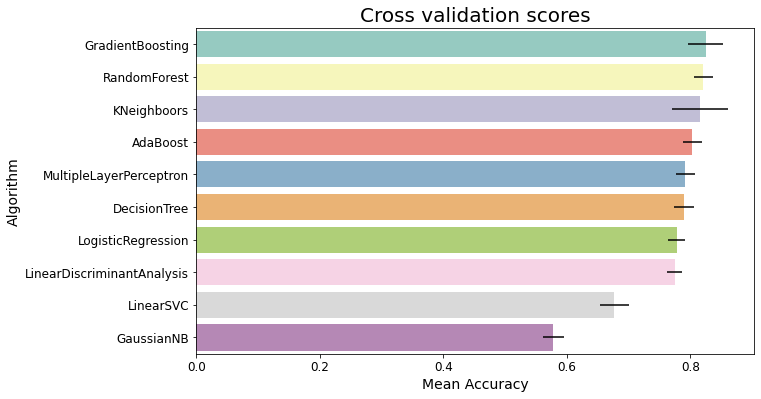

In [ ]:
# Accuracy Score Graph
plt.figure(figsize=(10,6))
ax = sns.barplot("CVAccMeans", "Algorithm", data=cv_res.sort_values(by='CVAccMeans', ascending=False), 
                 palette="Set3", orient="h", **{'xerr':cv_acc_std})
ax.set_xlabel("Mean Accuracy", size=14)
ax.set_title("Cross validation scores", size=20)
ax.tick_params(labelsize=12)
ax.yaxis.label.set_size(14)

In [ ]:
model_best_idx = cv_res_sorted.iloc[0].name
model_best = classifiers[model_best_idx][1]
model_best

GradientBoostingClassifier(random_state=2)

In [ ]:
model_best.fit(X_train, Y_train)
pred_model = model_best.predict(X_test)

Text(0.5, 1.0, 'Feature importance')

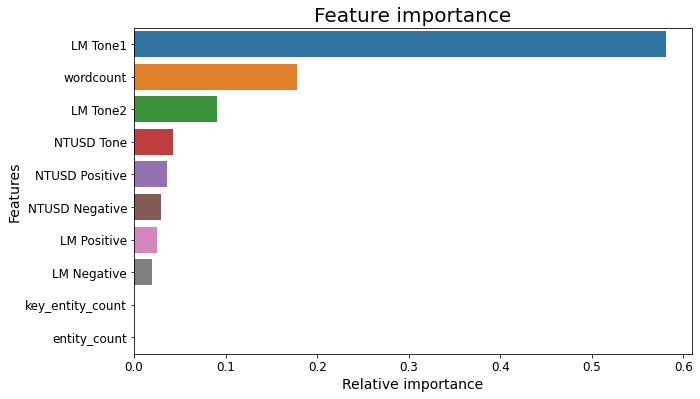

In [ ]:
# Feature Importance
fig, ax = plt.subplots(figsize=(10,6))

indices = np.argsort(model_best.feature_importances_)[::-1][:40]
g = sns.barplot(y=X_data.columns[indices][:40], x=model_best.feature_importances_[indices][:40] , orient='h', ax=ax)
g.set_xlabel("Relative importance", fontsize=14)
g.set_ylabel("Features", fontsize=14)
g.tick_params(labelsize=12)
g.set_title("Feature importance", fontsize=20)

### Performance

In [22]:
def metric(pred, target):
    score = precision_recall_fscore_support(pred, target)
    lex_score = pd.DataFrame(score,
                index=["precision", "recall", "fscore", "support"],
                columns=["positive", "negative"])
    lex_score.loc["accuracy",:] = accuracy_score(pred, target)
    return lex_score["negative"]  # return a pd.Series

In [ ]:
perf_summary = pd.DataFrame(index=["precision", "recall", "fscore", "support", "accuracy"],
                columns=["lexicon_tone", "lexicon_ml", "tfidf_log", "tfidf_rf", 
                         "rnn_model", "lstm_model", "rnn_embed", "lstm_embed", "BERT"])

In [ ]:
perf_summary["lexicon_tone"] = metric(lexi_df.pred_tone, lexi_df.negative)
perf_summary["lexicon_ml"] = metric(pred_model, Y_test)

In [ ]:
perf_summary

,lexicon_tone,lexicon_ml,tfidf_logit,tfidf_rf,rnn_model,lstm_model,rnn_embed,lstm_embed,BERT
precision,0.843038,0.873840,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recall,0.726621,0.830688,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fscore,0.780512,0.851718,NaN,NaN,NaN,NaN,NaN,NaN,NaN
support,3208.000000,567.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
accuracy,0.737748,0.836000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## B. Tfidf

build tfidf datatable for vocabs in all texts (not split data), then store into csv.  
get all unique vocabs.

In [ ]:
vectorizer = TfidfVectorizer(tokenizer=str.split)  # tokenize by space
matrix = vectorizer.fit_transform(tokens_df.sent.values)
vocab = vectorizer.get_feature_names()  # all vocabs

tfidf_df = pd.DataFrame(matrix.toarray(),  #tf_idf values
                    columns=vocab,  # vocab
                    index=lexi_df.index)  # news_id

In [ ]:
tfidf_df.to_csv("data/tfidf.csv.gz", compression="gzip")

In [ ]:
tfidf_df = pd.read_csv("data/tfidf.csv.gz", compression="gzip", index_col=0)
tfidf_df

,1号店,4s店,adobe,adyen,all,am,an,androidpay,applepay,ay,...,龙盛克来,龙腾,龙虎榜,龙行天下,龙飞凤舞,龙驹,龙龙,龚卓,龚卡鸽,龚子
id,,,,,,,,,,,,,,,,,,,,,
83dcefb7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1ad5be0d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6dd28e9b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1db87a14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fa005713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418e6a12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a8edcf27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dfeaffb1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
vocab = tfidf_df.columns.values.tolist()
vocab

['1号店',
 '4s店',
 'adobe',
 'adyen',
 'all',
 'am',
 'an',
 'androidpay',
 'applepay',
 'ay',
 'a座',
 'a股',
 'a轮',
 'bc',
 'bfc',
 'bluesnap',
 'bmfn博美',
 'braintree',
 'bri',
 'btworld',
 'bug',
 'buy',
 'b座',
 'b轮',
 'coo',
 'cp',
 'cry',
 'c座',
 'de',
 'doge',
 'eos',
 'epay',
 'er',
 'eth',
 'excel',
 'e人一铺',
 'e周行',
 'e周行网贷',
 'e租宝',
 'e赁宝',
 'e路商城',
 'e都市钱包',
 'fa',
 'fbc',
 'fbc区块链期货',
 'fcoin',
 'fi',
 'financial',
 'fomo',
 'fortune',
 'franklin',
 'function',
 'fxcm福汇',
 'fxword',
 'gan',
 'gap',
 'gemini',
 'gf',
 'grace',
 'h股',
 'iac',
 'iac蚁群',
 'ic',
 'ic卡',
 'igofx',
 'igofx平台',
 'important',
 'in',
 'izettle',
 'i财富',
 'i贷',
 'java',
 'jetlore',
 'jjptr',
 'kci',
 'kci区块链项目',
 'kevin',
 'kiki',
 'ky蓝天国际',
 'k线',
 'libra',
 'mg',
 'momo',
 'money',
 'mt',
 'must',
 'newdex',
 'ofo',
 'okex',
 'ok贷',
 'om',
 'or',
 'ovest',
 'parity',
 'part',
 'payment',
 'paypal',
 'pian',
 'plus',
 'ppmoney',
 'ppmoney网贷',
 'ppro',
 'pp基金',
 'pt',
 'ptfx',
 'ptfx普顿外汇',
 'p理财',
 'qos',


### Train ML models
1. logistic regression
2. random forest

In [ ]:
train_X, train_Y = tokens_df.sent.values[:4000], tokens_df.label.values[:4000]
valid_X, valid_Y = tokens_df.sent.values[4000:], tokens_df.label.values[4000:]

In [ ]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(tokenizer=str.split)),
    ('clf', dict(classifiers)["LogisticRegression"])])

pipeline.fit(train_X, train_Y)

pred_valid = pipeline.predict(valid_X)

perf_summary["tfidf_log"] = metric(pred_valid, valid_Y)

In [ ]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(tokenizer=str.split)),
    ('clf', dict(classifiers)["RandomForest"])])

pipeline.fit(train_X, train_Y)

pred_valid = pipeline.predict(valid_X)

perf_summary["tfidf_rf"] = metric(pred_valid, valid_Y)

C:\Users\wangy\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Feature importance')

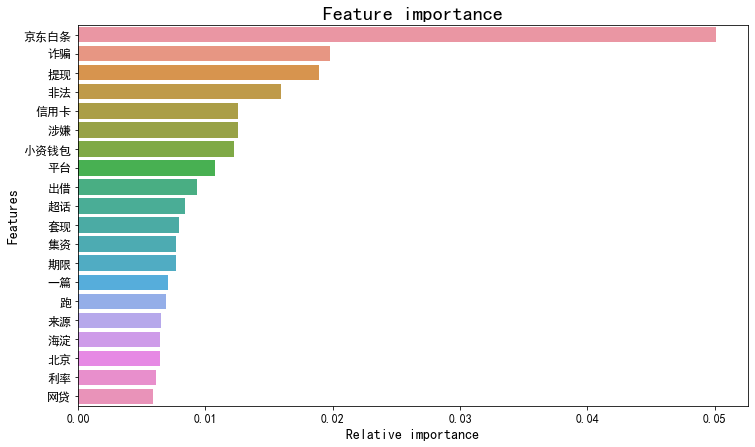

In [ ]:
# Feature Importance
plt.rcParams['font.sans-serif'] = ['SimHei'] # Or any other Chinese characters
fig, ax = plt.subplots(figsize=(12,7))

indices = np.argsort(pipeline[1].feature_importances_)[::-1][:20]
g = sns.barplot(y=np.array(pipeline[0].get_feature_names())[indices][:20], 
                x=pipeline[1].feature_importances_[indices][:20] , orient='h', ax=ax)
g.set_xlabel("Relative importance", fontsize=14)
g.set_ylabel("Features", fontsize=14)
g.tick_params(labelsize=12)
g.set_title("Feature importance", fontsize=20)

In [ ]:
perf_summary

,lexicon_tone,lexicon_ml,tfidf_logit,tfidf_rf,rnn_model,lstm_model,rnn_embed,lstm_embed,BERT
precision,0.843038,0.873840,0.964945,0.968635,NaN,NaN,NaN,NaN,NaN
recall,0.726621,0.830688,0.932264,0.958029,NaN,NaN,NaN,NaN,NaN
fscore,0.780512,0.851718,0.948323,0.963303,NaN,NaN,NaN,NaN,NaN
support,3208.000000,567.000000,561.000000,548.000000,NaN,NaN,NaN,NaN,NaN
accuracy,0.737748,0.836000,0.942714,0.959799,NaN,NaN,NaN,NaN,NaN


## C1. RNN/LSTM

Removing Outliers — Getting rid of extremely long or short reviews

In [ ]:
tokens_df2 = tokens_df[(tokens_df.wordcount>0) & (tokens_df.wordcount<1000)]
tokens_df2

,sent,label,wordcount
id,,,
83dcefb7,发表 博文 富金利 富金利 教 安全 提高 最大化 收益 网络 理财时代 参与 互联网 投资...,0,44.0
1ad5be0d,小资钱包 涉嫌 诈骗 超话 小资钱包 超话 迫切 急待 回归 活命钱 头号 直通 中纪委 超...,1,46.0
6dd28e9b,扫黑 除恶 诈骗犯 齐聚 海淀 保护伞 根深蒂固 黑社会 嚣张 跋扈 出借 走投无路 尊敬的...,1,40.0
1db87a14,平安银行车主贷 期限 长至 期 滴滴 司机 白户 逾期 家人 电话 不装 定位 额度 最高 万,0,15.0
fa005713,旺旺贷 跑 路 深圳 警方 确定 投资人 被骗,1,8.0
...,...,...,...
418e6a12,中国平安 平安普惠 客服 经理 林东 妈 真烂 卧藏 平安普惠 这种 藏污纳垢 专 搞 诈骗...,1,37.0
a8edcf27,钱宝网 事件 为例 项目 年化 收益率 高达 吸引 投资者 收益 构成 中拉 人头 推广 收...,1,40.0
dfeaffb1,雀尚枝头 号 提现 困难 资金链 断 现在 每月 返 没有 跑 路,1,12.0


Build RNN

In [ ]:
# import writen functions, classes
from datasets import create_cls_dataloader
# from models import RNNClsModel
from train_cls import train_rnn_cls, evaluate_your_model

In [ ]:
args = {"batch_size": 64,
        "embed_dim": 128,
        "hidden_dim": 32,
        "dense_dim": 16,
        "output_dim": 1,
        "lstm": 2,
        "dropout": 0.5,  # avoid overfitting
        "epochs": 20,
        "lr": 0.001}

In [ ]:
train_dataloader, valid_dataloader, vocabs = create_cls_dataloader(tokens_df2, vocab, 
                                                                   batch_size=args["batch_size"])

{'batch_size': 64, 'embed_dim': 128, 'hidden_dim': 32, 'dense_dim': 16, 'lstm': 2, 'dropout': 0.5, 'epochs': 20, 'lr': 0.001}
RNNClsModel(
  (embed): Embedding(27951, 128)
  (rnn): RNN(128, 32, batch_first=True, dropout=0.1)
  (fnn): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=32, out_features=1, bias=True)
    (4): Sigmoid()
  )
)


Epoch: 00	Train Loss: 41.1611	Train acc: 0.6190	Val acc: 0.6450


Epoch: 01	Train Loss: 35.7845	Train acc: 0.7140	Val acc: 0.6584


Epoch: 02	Train Loss: 29.7430	Train acc: 0.7883	Val acc: 0.7410


Epoch: 03	Train Loss: 18.6732	Train acc: 0.8895	Val acc: 0.8411


Epoch: 04	Train Loss: 10.9368	Train acc: 0.9447	Val acc: 0.8793


Epoch: 05	Train Loss: 6.5077	Train acc: 0.9700	Val acc: 0.8689


Epoch: 06	Train Loss: 3.9149	Train acc: 0.9842	Val acc: 0.8834


Epoch: 07	Train Loss: 2.4149	Train acc: 0.9930	Val acc: 0.8854


Epoch: 08	Train Loss: 1.7158	Train acc: 0.9945	Val acc: 0.8906


Epoch: 09	Train Loss: 1.8846	Train acc: 0.9925	Val acc: 0.8916


Epoch: 10	Train Loss: 1.1332	Train acc: 0.9962	Val acc: 0.8999


Epoch: 11	Train Loss: 0.6049	Train acc: 0.9985	Val acc: 0.8978


Epoch: 12	Train Loss: 0.4791	Train acc: 0.9988	Val acc: 0.9020


Epoch: 13	Train Loss: 0.4032	Train acc: 0.9990	Val acc: 0.8958


Epoch: 14	Train Loss: 1.3168	Train acc: 0.9938	Val acc: 0.8380


Epoch: 15	Train Loss: 1.2520	Train acc: 0.9940	Val acc: 0.8854


Epoch: 16	Train Loss: 0.4441	Train acc: 0.9980	Val acc: 0.8958


Epoch: 17	Train Loss: 0.3155	Train acc: 0.9990	Val acc: 0.8927


Epoch: 18	Train Loss: 0.2778	Train acc: 0.9985	Val acc: 0.8916


Epoch: 19	Train Loss: 0.2180	Train acc: 0.9992	Val acc: 0.8916


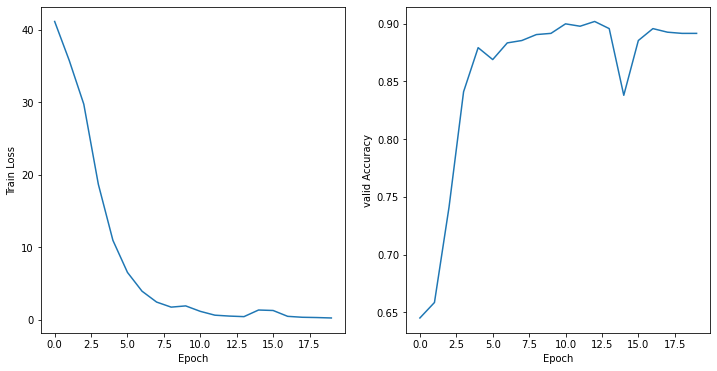

In [ ]:
rnn_model = train_rnn_cls(args, vocabs, train_dataloader, valid_dataloader, model_type="rnn") # learned weights

In [ ]:
val_preds, val_targets = evaluate_your_model(rnn_model, vocabs, valid_dataloader)
perf_summary["rnn_model"] = metric(val_preds, val_targets)

----------------------------------------
Valid Accuracy: 0.8916
----------------------------------------


Build LSTM

In [ ]:
# for a more complicated model, smaller step and train less
args["lr"] = 0.0001
args["epochs"] = 10

{'batch_size': 64, 'embed_dim': 128, 'hidden_dim': 32, 'dense_dim': 16, 'output_dim': 1, 'lstm': 2, 'dropout': 0.5, 'epochs': 20, 'lr': 0.001}
LSTMClsModel(
  (embedding): Embedding(27951, 128)
  (lstm): LSTM(128, 32, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (sig): Sigmoid()
)


Epoch: 00	Train Loss: 40.0173	Train acc: 0.6370	Val acc: 0.8246


Epoch: 01	Train Loss: 17.6266	Train acc: 0.8900	Val acc: 0.9009


Epoch: 02	Train Loss: 9.9413	Train acc: 0.9473	Val acc: 0.9216


Epoch: 03	Train Loss: 6.6797	Train acc: 0.9675	Val acc: 0.9236


Epoch: 04	Train Loss: 4.6691	Train acc: 0.9755	Val acc: 0.9226


Epoch: 05	Train Loss: 2.9372	Train acc: 0.9882	Val acc: 0.9309


Epoch: 06	Train Loss: 2.2610	Train acc: 0.9928	Val acc: 0.9216


Epoch: 07	Train Loss: 2.1501	Train acc: 0.9910	Val acc: 0.9350


Epoch: 08	Train Loss: 1.3220	Train acc: 0.9950	Val acc: 0.9247


Epoch: 09	Train Loss: 1.0503	Train acc: 0.9950	Val acc: 0.9319


Epoch: 10	Train Loss: 0.6574	Train acc: 0.9965	Val acc: 0.9319


Epoch: 11	Train Loss: 0.4951	Train acc: 0.9978	Val acc: 0.9319


Epoch: 12	Train Loss: 0.4452	Train acc: 0.9980	Val acc: 0.9319


Epoch: 13	Train Loss: 0.3899	Train acc: 0.9985	Val acc: 0.9288


Epoch: 14	Train Loss: 0.2488	Train acc: 0.9990	Val acc: 0.9288


Epoch: 15	Train Loss: 0.3660	Train acc: 0.9990	Val acc: 0.9247


Epoch: 16	Train Loss: 0.6178	Train acc: 0.9975	Val acc: 0.9226


Epoch: 17	Train Loss: 0.3647	Train acc: 0.9988	Val acc: 0.9257


Epoch: 18	Train Loss: 0.2468	Train acc: 0.9990	Val acc: 0.9298


Epoch: 19	Train Loss: 0.1747	Train acc: 0.9992	Val acc: 0.9288


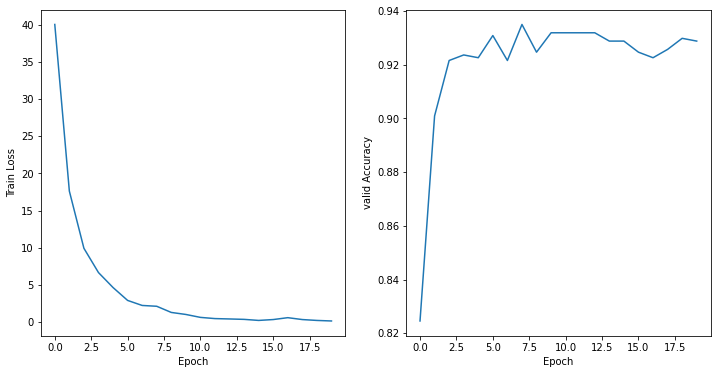

In [ ]:
lstm_model = train_rnn_cls(args, vocabs, train_dataloader, valid_dataloader, model_type="lstm") # learned weights

In [ ]:
val_preds, val_targets = evaluate_your_model(lstm_model, vocabs, valid_dataloader)
perf_summary["lstm_model"] = metric(val_preds, val_targets)

----------------------------------------
Valid Accuracy: 0.9288
----------------------------------------


## C2. RNN_embed

### Pre-trained embedding for the Chinese language
Tencent AI Lab Embedding Corpus for Chinese Words and Phrases:  
https://ai.tencent.com/ailab/nlp/en/embedding.html  
Method: Directional Skip-Gram

Embedding:  
The first line shows the total number of embeddings and their dimension size, separated by a space.   
In each line below, there are two fields separated by a space: the Chinese word or phrase and the corresponding embedding vector.  
For each embedding vector, its values in different dimensions are also separated by spaces.

In [ ]:
tar = tarfile.open(dict_folder+"tencent-ailab-embedding-zh-d100-v0.2.0-s.tar.gz", "r:gz")
member = tar.getmembers()[1]  # 'tencent-ailab-embedding-zh-d100-v0.2.0-s/tencent-ailab-embedding-zh-d100-v0.2.0-s.txt'
f = tar.extractfile(member)
lines = f.readlines()
embed_info = lines[0].decode('utf-8').split()
embed_num = int(embed_info[0])  # str to int
vector_size = int(embed_info[1])
print("(total number of embeddings, dimension size)", embed_info)

word_embed_zh = {}
for line in tqdm(lines[1:]):
    line = line.decode('utf-8')  # byte to str (Chinese)
    embed = line.split()
    word = embed[0]
    if word in vocab:  # only look for embedding for intended words
        word_embed_zh[word] = embed[1:]  # {word: vector list}
f.close()

(the total number of embeddings, their dimension size) ['2000000', '100']


100%|██████████████████████████████████████████████████████████████████████| 2000000/2000000 [16:22<00:00, 2036.06it/s]


In [ ]:
vocab_size = len(vocabs)+1
weight_matrix = np.zeros((vocab_size, vector_size))  # including <unk>, <pad>
words_found = 0

for key, (i, word) in enumerate(vocabs.int2obj.items()):
    try:
        weight_matrix[i] = word_embed_zh[word]
        words_found += 1
    except KeyError:
#         continue
        weight_matrix[i] = np.random.normal(scale=0.6, size=(vector_size,))

weight_matrix[vocab_size-1] = np.mean(weight_matrix, axis=0, keepdims=True)    #embedding for '<unk>' token.
weight_matrix[0] = np.zeros((1, weight_matrix.shape[1]))   #embedding for '<pad>' token.
    
print('{} words found out of {} words in vocab.'.format(words_found, len(vocab)))
print(weight_matrix.shape)

23100 words found out of 27949 words in vocab.
(27951, 100)


In [ ]:
weight_df = pd.DataFrame(weight_matrix.T,  #weights values
                        columns=["<pad>"]+vocab+["<unk>"])
weight_df  # first index: <pad>, last index: <unk>

,<pad>,1号店,4s店,adobe,adyen,all,am,an,androidpay,applepay,...,龙腾,龙虎榜,龙行天下,龙飞凤舞,龙驹,龙龙,龚卓,龚卡鸽,龚子,<unk>
0,0.0,-0.147853,-0.165347,-0.000404,0.147735,0.171910,0.220870,-0.024243,0.443148,0.044210,...,0.316445,-0.152258,0.533430,-0.473204,-0.131795,0.404568,-0.252893,0.263618,0.433495,0.110989
1,0.0,-0.345626,-0.092214,0.394179,0.409693,0.080666,0.022680,0.462581,0.722607,0.169505,...,-0.073709,-0.199244,0.232811,-0.072065,-0.629223,-0.745388,0.097779,-0.674144,-0.580936,-0.230273
2,0.0,0.253862,0.268156,0.127276,0.199152,0.278962,0.288854,-0.178233,-0.096295,0.098981,...,0.504984,0.114537,0.725289,0.411267,0.395164,0.364305,0.271251,0.733386,-0.078339,0.090226
3,0.0,0.416046,-0.358180,0.461539,0.917770,0.148124,0.488231,0.589897,0.088119,0.597106,...,-0.254760,-0.025436,-0.356524,-0.724206,-0.512584,-0.103836,1.723590,0.548927,-0.968710,-0.015845
4,0.0,-0.280401,-0.158378,0.178405,-0.012857,0.148535,0.149726,0.175893,0.884414,0.143587,...,-0.302447,0.003013,-0.493897,-0.365591,-0.494785,-0.217202,-0.575956,-0.199742,-0.581039,-0.217757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,-0.289676,-0.687870,-0.233161,-0.027044,0.188980,-0.178665,0.284531,-0.843847,0.130391,...,-0.028121,-0.175589,0.244906,-0.255739,-0.207554,0.258099,-0.429322,0.970615,-0.702262,-0.006198
96,0.0,0.150038,0.169224,-0.397657,-0.048692,0.018841,0.122007,-0.058962,0.567604,-0.264163,...,-0.165267,0.964912,-0.037306,-0.306209,-0.310767,0.052850,-0.327911,-0.180805,-0.009237,0.075330
97,0.0,0.021766,-0.454496,0.300496,-0.264568,-0.126196,-0.069806,-0.139201,0.238727,-0.301974,...,0.145007,0.445845,-0.073934,0.299303,0.011922,0.101796,0.255804,-0.154101,-0.389544,0.069933
98,0.0,0.239430,0.487216,-0.091057,0.342847,0.087634,0.367334,-0.150326,-0.710634,0.023197,...,0.182363,0.570161,-0.069614,-0.284817,-0.219694,-0.329698,0.641257,0.267710,-0.036357,0.036975


In [ ]:
weight_df.to_csv("data/weights.csv.gz", compression="gzip")

In [ ]:
# Save the embeddings which can be easily loaded in the future.
with open(dict_folder+'vocab.npy','wb') as f:
    np.save(f, weight_matrix)

Train RNN, using pretrained embeddings

In [ ]:
args = {"batch_size": 64,
        "embed_dim": 128,
        "hidden_dim": 32,
        "dense_dim": 16,
        "output_dim": 1,
        "lstm": 2,
        "dropout": 0.5,  # avoid overfitting
        "epochs": 20,
        "lr": 0.0001}

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


{'batch_size': 64, 'embed_dim': 128, 'hidden_dim': 32, 'dense_dim': 16, 'output_dim': 1, 'lstm': 2, 'dropout': 0.5, 'epochs': 20, 'lr': 0.001}
RNNClsModel(
  (embed): Embedding(27951, 100)
  (rnn): RNN(100, 32, batch_first=True, dropout=0.1)
  (fnn): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=32, out_features=1, bias=True)
    (4): Sigmoid()
  )
)


Epoch: 00	Train Loss: 36.4622	Train acc: 0.6987	Val acc: 0.8204


Epoch: 01	Train Loss: 21.6188	Train acc: 0.8692	Val acc: 0.8731


Epoch: 02	Train Loss: 17.4162	Train acc: 0.8980	Val acc: 0.8906


Epoch: 03	Train Loss: 16.0075	Train acc: 0.9070	Val acc: 0.8741


Epoch: 04	Train Loss: 15.1629	Train acc: 0.9107	Val acc: 0.8731


Epoch: 05	Train Loss: 14.7542	Train acc: 0.9117	Val acc: 0.8772


Epoch: 06	Train Loss: 14.1000	Train acc: 0.9150	Val acc: 0.8865


Epoch: 07	Train Loss: 12.9935	Train acc: 0.9210	Val acc: 0.8854


Epoch: 08	Train Loss: 13.4040	Train acc: 0.9203	Val acc: 0.8854


Epoch: 09	Train Loss: 12.8133	Train acc: 0.9223	Val acc: 0.8638


Epoch: 10	Train Loss: 11.5601	Train acc: 0.9305	Val acc: 0.9071


Epoch: 11	Train Loss: 10.8440	Train acc: 0.9355	Val acc: 0.8720


Epoch: 12	Train Loss: 10.7705	Train acc: 0.9355	Val acc: 0.9102


Epoch: 13	Train Loss: 9.9543	Train acc: 0.9395	Val acc: 0.9061


Epoch: 14	Train Loss: 9.3236	Train acc: 0.9435	Val acc: 0.8947


Epoch: 15	Train Loss: 8.6775	Train acc: 0.9465	Val acc: 0.8906


Epoch: 16	Train Loss: 8.9345	Train acc: 0.9495	Val acc: 0.9092


Epoch: 17	Train Loss: 7.4441	Train acc: 0.9577	Val acc: 0.9143


Epoch: 18	Train Loss: 7.1501	Train acc: 0.9600	Val acc: 0.8824


Epoch: 19	Train Loss: 8.6008	Train acc: 0.9483	Val acc: 0.9092


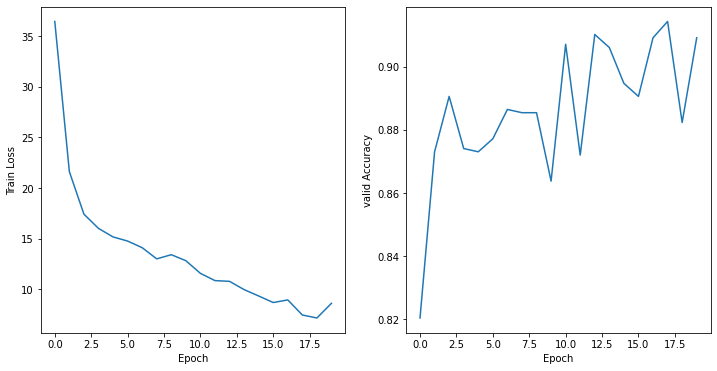

In [ ]:
rnn_embed = train_rnn_cls(args, vocabs, train_dataloader, valid_dataloader, 
                             weight_matrix=weight_matrix, model_type="rnn") # pretrained weights

In [ ]:
val_preds, val_targets = evaluate_your_model(rnn_embed, vocabs, valid_dataloader)
perf_summary["rnn_embed"] = metric(val_preds, val_targets)

----------------------------------------
Valid Accuracy: 0.9092
----------------------------------------


Train LSTM, using pretrained embeddings

{'batch_size': 64, 'embed_dim': 128, 'hidden_dim': 32, 'dense_dim': 16, 'output_dim': 1, 'lstm': 2, 'dropout': 0.5, 'epochs': 20, 'lr': 0.001}
LSTMClsModel(
  (embedding): Embedding(27951, 100)
  (lstm): LSTM(100, 32, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (sig): Sigmoid()
)


Epoch: 00	Train Loss: 36.8869	Train acc: 0.6723	Val acc: 0.8576


Epoch: 01	Train Loss: 19.6503	Train acc: 0.8888	Val acc: 0.8989


Epoch: 02	Train Loss: 15.7811	Train acc: 0.9090	Val acc: 0.9133


Epoch: 03	Train Loss: 14.7328	Train acc: 0.9127	Val acc: 0.9174


Epoch: 04	Train Loss: 13.6548	Train acc: 0.9220	Val acc: 0.9195


Epoch: 05	Train Loss: 12.1991	Train acc: 0.9307	Val acc: 0.9236


Epoch: 06	Train Loss: 11.9205	Train acc: 0.9323	Val acc: 0.9226


Epoch: 07	Train Loss: 12.7704	Train acc: 0.9257	Val acc: 0.9154


Epoch: 08	Train Loss: 11.8005	Train acc: 0.9313	Val acc: 0.9319


Epoch: 09	Train Loss: 10.6001	Train acc: 0.9415	Val acc: 0.9267


Epoch: 10	Train Loss: 9.9268	Train acc: 0.9445	Val acc: 0.9319


Epoch: 11	Train Loss: 9.3451	Train acc: 0.9450	Val acc: 0.9319


Epoch: 12	Train Loss: 9.5658	Train acc: 0.9475	Val acc: 0.9288


Epoch: 13	Train Loss: 9.4489	Train acc: 0.9457	Val acc: 0.9350


Epoch: 14	Train Loss: 8.6375	Train acc: 0.9487	Val acc: 0.9309


Epoch: 15	Train Loss: 8.1114	Train acc: 0.9515	Val acc: 0.9401


Epoch: 16	Train Loss: 7.7442	Train acc: 0.9545	Val acc: 0.9350


Epoch: 17	Train Loss: 7.8733	Train acc: 0.9497	Val acc: 0.9329


Epoch: 18	Train Loss: 7.9059	Train acc: 0.9547	Val acc: 0.9370


Epoch: 19	Train Loss: 8.1774	Train acc: 0.9487	Val acc: 0.9257


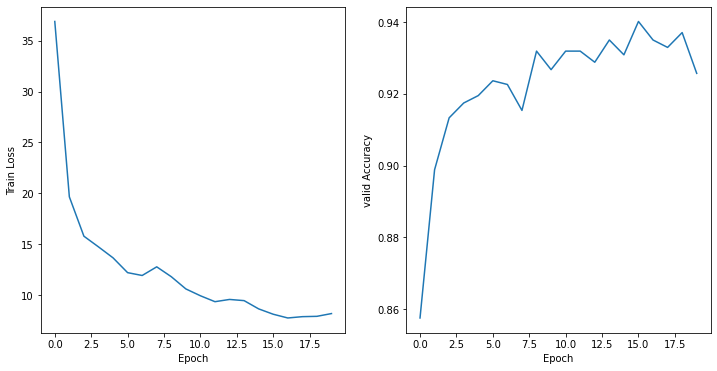

In [ ]:
lstm_embed = train_rnn_cls(args, vocabs, train_dataloader, valid_dataloader, 
                              weight_matrix=weight_matrix, model_type="lstm") # pretrained weights

In [ ]:
val_preds, val_targets = evaluate_your_model(lstm_embed, vocabs, valid_dataloader)
perf_summary["lstm_embed"] = metric(val_preds, val_targets)

----------------------------------------
Valid Accuracy: 0.9257
----------------------------------------


In [ ]:
perf_summary

,lexicon_tone,lexicon_ml,tfidf_logit,tfidf_rf,rnn_model,lstm_model,rnn_embed,lstm_embed,BERT
precision,0.843038,0.873840,0.964945,0.968635,0.918095,0.939048,0.942857,0.920000,NaN
recall,0.726621,0.830688,0.932264,0.958029,0.886029,0.930189,0.895118,0.941520,NaN
fscore,0.780512,0.851718,0.948323,0.963303,0.901777,0.934597,0.918367,0.930636,NaN
support,3208.000000,567.000000,561.000000,548.000000,544.000000,530.000000,553.000000,513.000000,NaN
accuracy,0.737748,0.836000,0.942714,0.959799,0.891641,0.928793,0.909185,0.925697,NaN


## D. Bert (pre-trained, hugging-face impementation)

## Bert finetuned 1
Chinese RoBERTa-Base Models for Text Classification    
model: https://huggingface.co/liam168/c2-roberta-base-finetuned-dianping-chinese   
label: positive/negative, with score

In [ ]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer,pipeline

model_name = "liam168/c2-roberta-base-finetuned-dianping-chinese"
class_num = 2
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=class_num)
tokenizer = AutoTokenizer.from_pretrained(model_name)
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

[{'label': 'negative', 'score': 0.9941973686218262}]

In [ ]:
bert_df = lexi_df[["text", "negative"]]
preds={}
for id, row in tqdm(bert_df.iterrows(), total=len(bert_df)):
    text = row[0]
    target = row[1]
    try:
        pred = classifier(text)
        preds[id] = pred
    except:
        print(id)

  0%|▎                                                                               | 21/4999 [00:06<25:43,  3.22it/s]

ac40252b


  1%|█                                                                               | 63/4999 [00:17<16:20,  5.04it/s]

43b0d90f


  1%|█▏                                                                              | 72/4999 [00:20<23:28,  3.50it/s]

0f37c730


  2%|█▋                                                                             | 104/4999 [00:29<24:48,  3.29it/s]

b838bf09
c8524b86


  3%|██▎                                                                            | 144/4999 [00:43<25:39,  3.15it/s]

87f4656c


  3%|██▎                                                                            | 150/4999 [00:44<19:19,  4.18it/s]

279e409d


  3%|██▋                                                                            | 169/4999 [00:48<12:02,  6.69it/s]

0cb3135e


  4%|███                                                                            | 196/4999 [00:57<27:17,  2.93it/s]

e6f186be


  4%|███▏                                                                           | 202/4999 [00:58<14:02,  5.69it/s]

25bc9201


  4%|███▎                                                                           | 211/4999 [01:00<19:45,  4.04it/s]

67e0040c


  5%|███▋                                                                           | 232/4999 [01:08<17:36,  4.51it/s]

04e10511


  5%|███▋                                                                           | 236/4999 [01:08<12:10,  6.52it/s]

9a8590b2


  5%|███▉                                                                           | 251/4999 [01:14<21:49,  3.63it/s]

8da291ec


  6%|████▊                                                                          | 303/4999 [01:31<14:34,  5.37it/s]

957bca9a


  6%|████▊                                                                          | 305/4999 [01:31<15:26,  5.07it/s]

6bd8d6dc


  6%|████▉                                                                          | 316/4999 [01:34<27:25,  2.85it/s]

a147e28d


  6%|█████                                                                          | 318/4999 [01:35<21:55,  3.56it/s]

46ffcf8a


  7%|█████▍                                                                         | 346/4999 [01:43<17:03,  4.54it/s]

eee1cc67


  7%|█████▌                                                                         | 352/4999 [01:44<17:12,  4.50it/s]

973d74c3


  7%|█████▊                                                                         | 366/4999 [01:51<52:12,  1.48it/s]

95de2e21


  7%|█████▊                                                                         | 370/4999 [01:51<23:47,  3.24it/s]

020cf7a9


  9%|██████▋                                                                        | 425/4999 [02:09<17:42,  4.31it/s]

5f0a1712
7afccce3


  9%|███████▏                                                                       | 457/4999 [02:18<13:56,  5.43it/s]

f631c6e5


  9%|███████▎                                                                       | 464/4999 [02:19<13:34,  5.57it/s]

3e0ff4c0


 10%|████████▏                                                                      | 516/4999 [02:38<20:57,  3.56it/s]

275e367e


 11%|████████▋                                                                      | 551/4999 [02:49<36:08,  2.05it/s]

69ddca8e


 12%|█████████                                                                      | 577/4999 [02:58<22:08,  3.33it/s]

fdc99bfe


 12%|█████████▏                                                                     | 584/4999 [03:00<21:54,  3.36it/s]

144d86e6


 12%|█████████▊                                                                     | 620/4999 [03:16<24:54,  2.93it/s]

e1f9d0ff


 13%|██████████                                                                     | 637/4999 [03:20<18:30,  3.93it/s]

c1662dd8


 13%|██████████▍                                                                    | 664/4999 [03:27<11:48,  6.12it/s]

cc7b2d12


 13%|██████████▌                                                                    | 667/4999 [03:27<13:25,  5.38it/s]

09581ffd


 15%|████████████▏                                                                  | 769/4999 [03:56<14:18,  4.93it/s]

63c96298


 15%|████████████▏                                                                  | 773/4999 [03:57<18:36,  3.79it/s]

03e95350


 16%|████████████▌                                                                  | 792/4999 [04:02<17:34,  3.99it/s]

72e42953


 16%|████████████▌                                                                  | 797/4999 [04:02<10:59,  6.37it/s]

a3c12a37


 16%|████████████▉                                                                  | 821/4999 [04:10<17:53,  3.89it/s]

616864ec


 18%|██████████████▎                                                                | 902/4999 [04:34<17:09,  3.98it/s]

c74306ea


 19%|███████████████                                                                | 954/4999 [04:51<14:41,  4.59it/s]

b1865c4b


 20%|███████████████▉                                                              | 1022/4999 [05:11<08:48,  7.53it/s]

703d73a9


 22%|████████████████▊                                                             | 1076/4999 [05:26<18:52,  3.46it/s]

abcd50a5


 22%|████████████████▉                                                             | 1084/4999 [05:29<13:15,  4.92it/s]

e74a4e9a


 22%|█████████████████▏                                                            | 1104/4999 [05:37<23:01,  2.82it/s]

7433dbf3


 23%|█████████████████▊                                                            | 1142/4999 [05:47<16:04,  4.00it/s]

47c7d346


 23%|█████████████████▉                                                            | 1146/4999 [05:48<14:22,  4.47it/s]

6b87449c


 23%|██████████████████                                                            | 1157/4999 [05:52<13:41,  4.67it/s]

82035984


 24%|██████████████████▋                                                           | 1199/4999 [06:04<17:52,  3.54it/s]

45e501da


 25%|███████████████████▎                                                          | 1241/4999 [06:18<12:55,  4.85it/s]

fb1e695e


 25%|███████████████████▊                                                          | 1267/4999 [06:28<28:42,  2.17it/s]

6880441a


 26%|███████████████████▉                                                          | 1278/4999 [06:31<16:26,  3.77it/s]

a21f704b


 26%|████████████████████                                                          | 1285/4999 [06:32<12:14,  5.06it/s]

cc03719c


 26%|████████████████████▍                                                         | 1312/4999 [06:40<12:06,  5.07it/s]

a6b43caa


 26%|████████████████████▋                                                         | 1323/4999 [06:42<13:20,  4.59it/s]

84c89b6f


 27%|████████████████████▉                                                         | 1340/4999 [06:47<18:29,  3.30it/s]

e6ec4868


 27%|█████████████████████                                                         | 1349/4999 [06:51<19:09,  3.17it/s]

6193ec8a
862bc18d


 28%|█████████████████████▊                                                        | 1396/4999 [07:05<28:41,  2.09it/s]

6da26fae


 28%|█████████████████████▉                                                        | 1402/4999 [07:06<15:47,  3.80it/s]

bbeaa8d3


 28%|██████████████████████▏                                                       | 1422/4999 [07:12<17:20,  3.44it/s]

6058d749


 29%|██████████████████████▎                                                       | 1434/4999 [07:15<11:39,  5.10it/s]

b735c22e


 29%|██████████████████████▌                                                       | 1443/4999 [07:16<11:54,  4.98it/s]

826e64b5


 29%|██████████████████████▌                                                       | 1445/4999 [07:17<09:51,  6.01it/s]

1b67350f


 30%|███████████████████████                                                       | 1479/4999 [07:28<22:45,  2.58it/s]

69295b0a


 30%|███████████████████████▏                                                      | 1484/4999 [07:29<16:52,  3.47it/s]

07355add


 30%|███████████████████████▌                                                      | 1508/4999 [07:36<11:10,  5.20it/s]

749926aa


 31%|████████████████████████▏                                                     | 1549/4999 [07:49<18:31,  3.10it/s]

dda2f75d


 32%|████████████████████████▋                                                     | 1585/4999 [08:00<10:58,  5.19it/s]

1daabff2


 32%|█████████████████████████                                                     | 1604/4999 [08:05<14:39,  3.86it/s]

97c81bda


 32%|█████████████████████████▏                                                    | 1613/4999 [08:06<09:47,  5.76it/s]

feb9de14


 33%|█████████████████████████▎                                                    | 1626/4999 [08:11<16:25,  3.42it/s]

5586ed2c


 33%|█████████████████████████▌                                                    | 1640/4999 [08:16<30:24,  1.84it/s]

1c68d5c5


 34%|██████████████████████████▌                                                   | 1702/4999 [08:34<09:49,  5.59it/s]

2c7c65db


 34%|██████████████████████████▊                                                   | 1718/4999 [08:40<18:48,  2.91it/s]

4f7d64c6


 35%|███████████████████████████▌                                                  | 1767/4999 [08:56<22:20,  2.41it/s]

a0b16fdd


 36%|███████████████████████████▊                                                  | 1779/4999 [09:01<23:25,  2.29it/s]

2e788714


 37%|█████████████████████████████▏                                                | 1874/4999 [09:31<48:24,  1.08it/s]

3e97a6e8
4990967e


 38%|█████████████████████████████▍                                                | 1884/4999 [09:33<12:37,  4.11it/s]

6616895c


 38%|██████████████████████████████                                                | 1924/4999 [09:43<09:42,  5.27it/s]

2cd0d094


 39%|██████████████████████████████                                                | 1928/4999 [09:45<19:11,  2.67it/s]

9a5f9e0c


 39%|██████████████████████████████▎                                               | 1939/4999 [09:49<35:29,  1.44it/s]

af043897
48bc1590


 40%|███████████████████████████████▎                                              | 2007/4999 [10:09<05:44,  8.69it/s]

b9e153fe
83f95325


 40%|███████████████████████████████▌                                              | 2019/4999 [10:12<11:57,  4.15it/s]

28c6601d


 41%|███████████████████████████████▉                                              | 2043/4999 [10:20<14:51,  3.32it/s]

55b19458


 41%|███████████████████████████████▉                                              | 2050/4999 [10:21<08:06,  6.06it/s]

45fb511f


 42%|████████████████████████████████▍                                             | 2081/4999 [10:31<09:45,  4.98it/s]

3772ff72


 42%|████████████████████████████████▌                                             | 2085/4999 [10:32<10:14,  4.74it/s]

e88c7424
ff4ccd57


 43%|█████████████████████████████████▌                                            | 2148/4999 [10:49<07:21,  6.45it/s]

d1ad5cf9


 43%|█████████████████████████████████▌                                            | 2154/4999 [10:50<11:08,  4.25it/s]

6fb18c50


 43%|█████████████████████████████████▋                                            | 2159/4999 [10:52<14:17,  3.31it/s]

5aea2acb


 45%|███████████████████████████████████▏                                          | 2252/4999 [11:13<09:30,  4.82it/s]

f235a158


 46%|███████████████████████████████████▊                                          | 2294/4999 [11:25<23:28,  1.92it/s]

d38f8e65


 46%|███████████████████████████████████▉                                          | 2304/4999 [11:28<11:25,  3.93it/s]

f71edb18


 47%|████████████████████████████████████▎                                         | 2327/4999 [11:34<09:08,  4.87it/s]

323de9f7


 48%|█████████████████████████████████████▏                                        | 2382/4999 [11:48<05:40,  7.69it/s]

4e887785


 49%|██████████████████████████████████████                                        | 2436/4999 [12:03<11:09,  3.83it/s]

2b2f8942


 49%|██████████████████████████████████████▌                                       | 2473/4999 [12:10<05:19,  7.89it/s]

8883244b


 50%|██████████████████████████████████████▋                                       | 2483/4999 [12:12<06:09,  6.80it/s]

b3030ae2


 50%|███████████████████████████████████████▏                                      | 2508/4999 [12:23<06:49,  6.09it/s]

fe6606af


 51%|███████████████████████████████████████▊                                      | 2548/4999 [12:36<08:20,  4.90it/s]

549b5fa0


 52%|████████████████████████████████████████▏                                     | 2575/4999 [12:43<06:11,  6.52it/s]

6cddf9f1


 52%|████████████████████████████████████████▌                                     | 2598/4999 [12:50<10:10,  3.94it/s]

38c1e02e


 54%|█████████████████████████████████████████▊                                    | 2676/4999 [13:09<05:02,  7.68it/s]

2d05bb92


 54%|█████████████████████████████████████████▊                                    | 2683/4999 [13:11<06:46,  5.70it/s]

185e1d09


 55%|██████████████████████████████████████████▌                                   | 2728/4999 [13:21<05:49,  6.49it/s]

c1290822


 56%|███████████████████████████████████████████▋                                  | 2799/4999 [13:40<10:34,  3.47it/s]

8c8bc407


 57%|████████████████████████████████████████████▍                                 | 2851/4999 [13:57<07:40,  4.67it/s]

8ecd7a5e


 59%|█████████████████████████████████████████████▊                                | 2934/4999 [14:22<05:27,  6.31it/s]

482191bd


 59%|█████████████████████████████████████████████▊                                | 2937/4999 [14:22<04:05,  8.40it/s]

4f4c55a4


 59%|█████████████████████████████████████████████▊                                | 2938/4999 [14:23<05:34,  6.16it/s]

630cc27e


 59%|█████████████████████████████████████████████▉                                | 2945/4999 [14:24<09:16,  3.69it/s]

0a7d07b0


 59%|██████████████████████████████████████████████                                | 2956/4999 [14:27<09:07,  3.73it/s]

ea4f5683


 59%|██████████████████████████████████████████████▏                               | 2961/4999 [14:29<11:54,  2.85it/s]

4d48b76b


 59%|██████████████████████████████████████████████▏                               | 2964/4999 [14:30<10:15,  3.30it/s]

2ae2fa97


 60%|██████████████████████████████████████████████▊                               | 2999/4999 [14:40<08:46,  3.80it/s]

fb2041de


 60%|██████████████████████████████████████████████▉                               | 3011/4999 [14:42<08:10,  4.05it/s]

5ef7ab38


 61%|███████████████████████████████████████████████▎                              | 3032/4999 [14:49<08:34,  3.82it/s]

3440e60e


 61%|███████████████████████████████████████████████▊                              | 3064/4999 [14:59<07:00,  4.60it/s]

462ef04e


 61%|███████████████████████████████████████████████▉                              | 3070/4999 [15:00<09:23,  3.43it/s]

1a04931b


 61%|███████████████████████████████████████████████▉                              | 3072/4999 [15:01<07:49,  4.11it/s]

6a6e6794


 62%|████████████████████████████████████████████████▌                             | 3113/4999 [15:14<05:04,  6.20it/s]

ee30f3a3


 63%|█████████████████████████████████████████████████▏                            | 3154/4999 [15:23<04:36,  6.67it/s]

7b432c5f


 64%|█████████████████████████████████████████████████▌                            | 3175/4999 [15:30<09:05,  3.35it/s]

256dadc5


 64%|█████████████████████████████████████████████████▌                            | 3179/4999 [15:31<06:03,  5.00it/s]

42c7e039


 64%|█████████████████████████████████████████████████▊                            | 3189/4999 [15:35<15:54,  1.90it/s]

38ddd065
d6d3b149


 64%|█████████████████████████████████████████████████▉                            | 3199/4999 [15:37<09:02,  3.32it/s]

73370a43


 64%|██████████████████████████████████████████████████                            | 3207/4999 [15:39<05:12,  5.74it/s]

0d61ced3


 65%|██████████████████████████████████████████████████▍                           | 3231/4999 [15:44<04:48,  6.13it/s]

9bb0f512


 66%|███████████████████████████████████████████████████▎                          | 3285/4999 [16:01<11:59,  2.38it/s]

7961fec3


 66%|███████████████████████████████████████████████████▎                          | 3290/4999 [16:02<07:11,  3.96it/s]

7e0c3ada


 66%|███████████████████████████████████████████████████▎                          | 3292/4999 [16:02<07:23,  3.85it/s]

00bd4667


 66%|███████████████████████████████████████████████████▌                          | 3307/4999 [16:05<04:38,  6.07it/s]

2a102305


 66%|███████████████████████████████████████████████████▋                          | 3310/4999 [16:06<04:40,  6.02it/s]

54a15fb8


 67%|████████████████████████████████████████████████████                          | 3333/4999 [16:12<05:44,  4.83it/s]

a71f4334


 67%|████████████████████████████████████████████████████                          | 3340/4999 [16:14<05:18,  5.21it/s]

5ed19b6b


 67%|████████████████████████████████████████████████████▏                         | 3347/4999 [16:15<04:50,  5.69it/s]

75fcc8a8


 68%|████████████████████████████████████████████████████▋                         | 3375/4999 [16:21<05:37,  4.81it/s]

99f64b4b


 68%|█████████████████████████████████████████████████████▏                        | 3411/4999 [16:34<11:40,  2.27it/s]

29384224


 68%|█████████████████████████████████████████████████████▍                        | 3423/4999 [16:37<06:25,  4.09it/s]

7ca46d5a


 70%|██████████████████████████████████████████████████████▎                       | 3483/4999 [16:55<08:13,  3.07it/s]

4c96ed17


 70%|██████████████████████████████████████████████████████▊                       | 3512/4999 [17:02<06:15,  3.96it/s]

e64bcc5d


 70%|██████████████████████████████████████████████████████▉                       | 3524/4999 [17:06<04:08,  5.93it/s]

cd669f9e


 71%|███████████████████████████████████████████████████████▍                      | 3556/4999 [17:15<06:17,  3.82it/s]

7e80f7d0


 72%|███████████████████████████████████████████████████████▊                      | 3577/4999 [17:21<06:29,  3.66it/s]

8d3eeb5c


 72%|███████████████████████████████████████████████████████▉                      | 3586/4999 [17:23<05:20,  4.41it/s]

d1148809


 73%|████████████████████████████████████████████████████████▉                     | 3651/4999 [17:40<04:50,  4.64it/s]

23cd1a09


 74%|█████████████████████████████████████████████████████████▍                    | 3679/4999 [17:45<03:51,  5.71it/s]

b6fc9963


 75%|██████████████████████████████████████████████████████████▌                   | 3756/4999 [18:04<02:49,  7.33it/s]

97873e20


 77%|████████████████████████████████████████████████████████████                  | 3847/4999 [18:27<04:04,  4.72it/s]

ad609e05


 79%|█████████████████████████████████████████████████████████████▎                | 3931/4999 [18:46<02:43,  6.54it/s]

500c5b4f


 79%|█████████████████████████████████████████████████████████████▌                | 3947/4999 [18:50<05:05,  3.45it/s]

90464f76


 79%|█████████████████████████████████████████████████████████████▉                | 3972/4999 [18:55<03:05,  5.55it/s]

0de4522d


 79%|██████████████████████████████████████████████████████████████                | 3974/4999 [18:56<03:54,  4.37it/s]

ed31bb33


 80%|██████████████████████████████████████████████████████████████▋               | 4017/4999 [19:05<03:55,  4.17it/s]

657d1bbc


 81%|███████████████████████████████████████████████████████████████               | 4039/4999 [19:10<04:22,  3.66it/s]

f6048ed5


 81%|███████████████████████████████████████████████████████████████▏              | 4046/4999 [19:11<03:25,  4.64it/s]

719c921a


 81%|███████████████████████████████████████████████████████████████▏              | 4050/4999 [19:12<02:15,  7.00it/s]

18ed57d4


 81%|███████████████████████████████████████████████████████████████▍              | 4065/4999 [19:15<03:51,  4.04it/s]

13b8411d


 82%|████████████████████████████████████████████████████████████████▎             | 4120/4999 [19:30<03:40,  3.99it/s]

d9c0cd61


 83%|████████████████████████████████████████████████████████████████▋             | 4149/4999 [19:36<03:28,  4.08it/s]

1b6983ba


 83%|█████████████████████████████████████████████████████████████████             | 4169/4999 [19:41<03:57,  3.49it/s]

0e4a602b


 84%|█████████████████████████████████████████████████████████████████▎            | 4184/4999 [19:44<03:05,  4.39it/s]

f32ff495


 85%|██████████████████████████████████████████████████████████████████▏           | 4240/4999 [19:58<02:25,  5.23it/s]

7f2376ed


 85%|██████████████████████████████████████████████████████████████████▌           | 4268/4999 [20:05<02:27,  4.96it/s]

ea12f587


 86%|██████████████████████████████████████████████████████████████████▊           | 4284/4999 [20:09<04:42,  2.53it/s]

f7a28827


 86%|███████████████████████████████████████████████████████████████████           | 4298/4999 [20:11<01:43,  6.75it/s]

b47e288b


 86%|███████████████████████████████████████████████████████████████████▏          | 4309/4999 [20:13<01:17,  8.93it/s]

f8f936b4
8ffe0622


 87%|███████████████████████████████████████████████████████████████████▌          | 4327/4999 [20:16<01:22,  8.12it/s]

eb92c326
729b929c


 87%|███████████████████████████████████████████████████████████████████▋          | 4336/4999 [20:18<01:55,  5.74it/s]

7511eea8


 87%|███████████████████████████████████████████████████████████████████▋          | 4339/4999 [20:18<01:57,  5.62it/s]

f26e4a4a


 87%|███████████████████████████████████████████████████████████████████▊          | 4346/4999 [20:20<02:23,  4.56it/s]

d57bcb59


 87%|████████████████████████████████████████████████████████████████████▏         | 4373/4999 [20:26<01:52,  5.55it/s]

74343cb2


 88%|████████████████████████████████████████████████████████████████████▎         | 4377/4999 [20:27<01:40,  6.20it/s]

f4265c49


 88%|████████████████████████████████████████████████████████████████████▉         | 4420/4999 [20:36<02:18,  4.19it/s]

7f687b8f


 89%|█████████████████████████████████████████████████████████████████████▏        | 4431/4999 [20:38<01:27,  6.49it/s]

0888f334


 89%|█████████████████████████████████████████████████████████████████████▎        | 4439/4999 [20:40<02:16,  4.09it/s]

c193130b


 89%|█████████████████████████████████████████████████████████████████████▌        | 4459/4999 [20:45<02:02,  4.42it/s]

3cf687b5


 89%|█████████████████████████████████████████████████████████████████████▌        | 4462/4999 [20:45<01:39,  5.39it/s]

cbe3d7d8


 90%|██████████████████████████████████████████████████████████████████████▎       | 4504/4999 [20:56<01:14,  6.61it/s]

aac64c4f


 90%|██████████████████████████████████████████████████████████████████████▌       | 4523/4999 [21:01<01:40,  4.72it/s]

50ce1ce8


 91%|██████████████████████████████████████████████████████████████████████▋       | 4533/4999 [21:02<00:59,  7.85it/s]

d7b1b80a


 92%|███████████████████████████████████████████████████████████████████████▉      | 4608/4999 [21:21<01:49,  3.56it/s]

39fd85b0
2e3d3cc3


 93%|████████████████████████████████████████████████████████████████████████▋     | 4662/4999 [21:33<00:53,  6.34it/s]

3189a3ac


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4700/4999 [21:41<00:31,  9.54it/s]

3c731b4b


 95%|██████████████████████████████████████████████████████████████████████████    | 4743/4999 [21:54<00:40,  6.39it/s]

49b1416c


 95%|██████████████████████████████████████████████████████████████████████████    | 4744/4999 [21:54<00:46,  5.47it/s]

d05fa8fb


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4767/4999 [22:02<01:06,  3.46it/s]

25a9a274


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4776/4999 [22:05<00:40,  5.52it/s]

73f305f2


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4792/4999 [22:08<00:43,  4.74it/s]

3f93a3e0


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4804/4999 [22:10<00:30,  6.30it/s]

6c05c60b


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4831/4999 [22:15<00:33,  4.99it/s]

234450cc


 98%|████████████████████████████████████████████████████████████████████████████  | 4875/4999 [22:25<00:24,  4.98it/s]

7eac59ae


 98%|████████████████████████████████████████████████████████████████████████████▊ | 4922/4999 [22:36<00:16,  4.77it/s]

85888ae7


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4932/4999 [22:38<00:11,  6.01it/s]

2eb7b9df


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4955/4999 [22:43<00:09,  4.53it/s]

69820904


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4958/4999 [22:44<00:08,  4.98it/s]

a51777c0


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4971/4999 [22:46<00:04,  6.40it/s]

ed3b251e


100%|██████████████████████████████████████████████████████████████████████████████| 4999/4999 [22:52<00:00,  3.64it/s]


In [ ]:
for i, value in preds.items():
    if value[0]["label"] == "negative":
        bert_df.loc[i, "pred"] = 1  # if label is negative, value = 1
    else:
        bert_df.loc[i, "pred"] = 0

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [21]:
bert_df2 = bert_df.dropna()
bert_df2["pred"] = bert_df2.pred.astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
perf_summary["BERT"] = metric(bert_df2.pred, bert_df2.negative)  # this model has lower recall, higher precision

In [ ]:
perf_summary

,lexicon_tone,lexicon_ml,tfidf_logit,tfidf_rf,rnn_model,lstm_model,rnn_embed,lstm_embed,BERT
precision,0.843038,0.873840,0.964945,0.968635,0.918095,0.939048,0.942857,0.920000,0.969474
recall,0.726621,0.830688,0.932264,0.958029,0.886029,0.930189,0.895118,0.941520,0.748955
fscore,0.780512,0.851718,0.948323,0.963303,0.901777,0.934597,0.918367,0.930636,0.845066
support,3208.000000,567.000000,561.000000,548.000000,544.000000,530.000000,553.000000,513.000000,3350.000000
accuracy,0.737748,0.836000,0.942714,0.959799,0.891641,0.928793,0.909185,0.925697,0.808053


In [ ]:
perf_summary.to_csv("data/perf.csv")

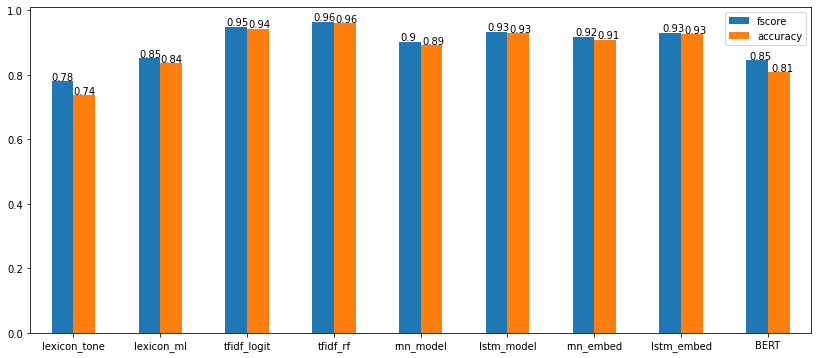

In [ ]:
ax = perf_summary.loc[["fscore", "accuracy"], :].T.plot.bar(rot=0, figsize=(14,6))

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))

## Bert finetuned 2
Base model:  
Chinese BERT with Whole Word Masking  
https://github.com/ymcui/Chinese-BERT-wwm  

Finetuned:  
We collect 8 sentiment datasets in the Chinese domain for finetune, with a total of 227347 samples.  
https://huggingface.co/IDEA-CCNL/Erlangshen-Roberta-110M-Sentiment  

In [11]:
# can use GPU in google collab
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [14]:
from transformers import BertForSequenceClassification
from transformers import BertTokenizer
import torch

tokenizer=BertTokenizer.from_pretrained('IDEA-CCNL/Erlangshen-Roberta-110M-Sentiment')
model=BertForSequenceClassification.from_pretrained('IDEA-CCNL/Erlangshen-Roberta-110M-Sentiment').to(device)

text='今天心情不好'

output=model(torch.tensor([tokenizer.encode(text)]).to(device))
print(torch.nn.functional.softmax(output.logits,dim=-1))

Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/749 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/390M [00:00<?, ?B/s]

tensor([[0.9551, 0.0449]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [17]:
bert_df = train_data[["text", "negative"]]
preds={}
for id, row in tqdm(bert_df.iterrows(), total=len(bert_df)):
    text = row[0]
    target = row[1]
    try:
        output = model(torch.tensor([tokenizer.encode(text)]).to(device))
        pred = torch.nn.functional.softmax(output.logits,dim=-1)[0]>=0.5  # [prob negative, prob positive]
        preds[id] = pred
    except:
        print(id)

  0%|          | 23/4999 [00:01<04:22, 18.98it/s]

ac40252b


  1%|▏         | 66/4999 [00:03<05:15, 15.64it/s]

43b0d90f


  2%|▏         | 76/4999 [00:04<05:59, 13.70it/s]

0f37c730


  2%|▏         | 106/4999 [00:06<05:58, 13.65it/s]

b838bf09
c8524b86


  3%|▎         | 146/4999 [00:09<05:09, 15.67it/s]

87f4656c


  3%|▎         | 152/4999 [00:09<05:46, 14.01it/s]

279e409d


  3%|▎         | 169/4999 [00:10<05:15, 15.31it/s]

0cb3135e


  4%|▍         | 197/4999 [00:12<05:33, 14.42it/s]

e6f186be


  4%|▍         | 204/4999 [00:13<05:10, 15.43it/s]

25bc9201


  4%|▍         | 213/4999 [00:13<06:29, 12.28it/s]

67e0040c


  5%|▍         | 235/4999 [00:15<05:08, 15.45it/s]

04e10511
9a8590b2


  5%|▌         | 257/4999 [00:16<02:59, 26.42it/s]

8da291ec


  6%|▌         | 307/4999 [00:17<02:00, 39.03it/s]

957bca9a
6bd8d6dc


  6%|▋         | 321/4999 [00:17<01:57, 39.88it/s]

a147e28d
46ffcf8a


  7%|▋         | 351/4999 [00:18<02:03, 37.57it/s]

eee1cc67
973d74c3


  7%|▋         | 373/4999 [00:19<02:10, 35.51it/s]

95de2e21
020cf7a9


  9%|▊         | 431/4999 [00:21<02:15, 33.82it/s]

5f0a1712
7afccce3


  9%|▉         | 464/4999 [00:21<01:55, 39.35it/s]

f631c6e5
3e0ff4c0


 10%|█         | 517/4999 [00:23<03:21, 22.29it/s]

275e367e


 11%|█         | 558/4999 [00:25<02:32, 29.15it/s]

69ddca8e


 12%|█▏        | 582/4999 [00:26<02:10, 33.88it/s]

fdc99bfe


 12%|█▏        | 591/4999 [00:26<01:56, 37.98it/s]

144d86e6


 13%|█▎        | 629/4999 [00:27<02:04, 34.99it/s]

e1f9d0ff


 13%|█▎        | 642/4999 [00:27<02:03, 35.36it/s]

c1662dd8


 13%|█▎        | 669/4999 [00:28<01:45, 41.03it/s]

cc7b2d12
09581ffd


 15%|█▌        | 774/4999 [00:31<02:01, 34.68it/s]

63c96298
03e95350


 16%|█▌        | 804/4999 [00:32<01:52, 37.26it/s]

a3c12a37


 17%|█▋        | 825/4999 [00:33<02:06, 32.87it/s]

616864ec


 18%|█▊        | 908/4999 [00:35<02:11, 31.15it/s]

c74306ea


 19%|█▉        | 958/4999 [00:37<02:09, 31.29it/s]

b1865c4b


 21%|██        | 1026/4999 [00:39<01:40, 39.54it/s]

703d73a9


 22%|██▏       | 1081/4999 [00:40<01:58, 32.99it/s]

abcd50a5
e74a4e9a


 22%|██▏       | 1110/4999 [00:41<02:00, 32.16it/s]

7433dbf3


 23%|██▎       | 1149/4999 [00:42<01:54, 33.55it/s]

47c7d346
6b87449c


 23%|██▎       | 1164/4999 [00:43<01:37, 39.15it/s]

82035984


 24%|██▍       | 1205/4999 [00:44<01:57, 32.26it/s]

45e501da


 25%|██▍       | 1247/4999 [00:45<01:42, 36.78it/s]

fb1e695e


 26%|██▌       | 1276/4999 [00:46<01:46, 34.86it/s]

6880441a


 26%|██▌       | 1284/4999 [00:46<01:45, 35.20it/s]

a21f704b
cc03719c


 26%|██▋       | 1319/4999 [00:47<01:32, 39.88it/s]

a6b43caa


 27%|██▋       | 1329/4999 [00:47<01:31, 40.06it/s]

84c89b6f


 27%|██▋       | 1344/4999 [00:48<01:35, 38.09it/s]

e6ec4868


 27%|██▋       | 1353/4999 [00:48<01:51, 32.62it/s]

6193ec8a
862bc18d


 28%|██▊       | 1402/4999 [00:50<01:44, 34.55it/s]

6da26fae
bbeaa8d3


 29%|██▊       | 1429/4999 [00:50<01:32, 38.62it/s]

6058d749


 29%|██▉       | 1444/4999 [00:51<01:26, 40.92it/s]

b735c22e
826e64b5


 29%|██▉       | 1449/4999 [00:51<01:23, 42.33it/s]

1b67350f


 30%|██▉       | 1484/4999 [00:52<01:50, 31.95it/s]

69295b0a
07355add


 30%|███       | 1514/4999 [00:53<01:34, 37.02it/s]

749926aa


 31%|███       | 1553/4999 [00:54<01:57, 29.29it/s]

dda2f75d


 32%|███▏      | 1593/4999 [00:55<01:23, 40.57it/s]

1daabff2


 32%|███▏      | 1613/4999 [00:56<01:25, 39.55it/s]

97c81bda
feb9de14


 33%|███▎      | 1632/4999 [00:56<01:31, 36.94it/s]

5586ed2c


 33%|███▎      | 1644/4999 [00:56<01:47, 31.33it/s]

1c68d5c5


 34%|███▍      | 1705/4999 [00:58<01:31, 35.87it/s]

2c7c65db


 35%|███▍      | 1725/4999 [00:59<01:49, 29.80it/s]

4f7d64c6


 35%|███▌      | 1772/4999 [01:00<01:45, 30.71it/s]

a0b16fdd


 36%|███▌      | 1784/4999 [01:01<01:59, 26.88it/s]

2e788714


 38%|███▊      | 1879/4999 [01:03<01:43, 30.08it/s]

3e97a6e8
4990967e


 38%|███▊      | 1888/4999 [01:04<01:27, 35.74it/s]

6616895c


 39%|███▊      | 1930/4999 [01:05<01:30, 33.79it/s]

2cd0d094
9a5f9e0c


 39%|███▉      | 1947/4999 [01:05<01:26, 35.15it/s]

af043897
48bc1590


 40%|████      | 2010/4999 [01:07<01:22, 36.08it/s]

b9e153fe
83f95325


 40%|████      | 2023/4999 [01:07<01:29, 33.30it/s]

28c6601d


 41%|████      | 2051/4999 [01:08<01:18, 37.48it/s]

55b19458
45fb511f


 42%|████▏     | 2087/4999 [01:09<01:14, 39.03it/s]

3772ff72
e88c7424
ff4ccd57


 43%|████▎     | 2154/4999 [01:11<01:11, 40.04it/s]

d1ad5cf9
6fb18c50


 43%|████▎     | 2164/4999 [01:11<01:09, 40.58it/s]

5aea2acb


 45%|████▌     | 2257/4999 [01:14<01:13, 37.36it/s]

f235a158


 46%|████▌     | 2300/4999 [01:15<01:22, 32.62it/s]

d38f8e65


 46%|████▌     | 2310/4999 [01:15<01:22, 32.50it/s]

f71edb18


 47%|████▋     | 2331/4999 [01:16<01:18, 33.92it/s]

323de9f7


 48%|████▊     | 2386/4999 [01:18<01:13, 35.58it/s]

4e887785


 49%|████▉     | 2441/4999 [01:19<01:05, 39.07it/s]

2b2f8942


 50%|████▉     | 2477/4999 [01:20<01:02, 40.30it/s]

8883244b


 50%|████▉     | 2487/4999 [01:20<01:12, 34.77it/s]

b3030ae2


 50%|█████     | 2516/4999 [01:21<01:10, 35.14it/s]

fe6606af


 51%|█████     | 2554/4999 [01:23<01:09, 35.17it/s]

549b5fa0


 52%|█████▏    | 2580/4999 [01:23<01:06, 36.47it/s]

6cddf9f1


 52%|█████▏    | 2606/4999 [01:24<01:04, 36.92it/s]

38c1e02e


 54%|█████▍    | 2688/4999 [01:27<01:04, 36.05it/s]

185e1d09


 55%|█████▍    | 2734/4999 [01:28<00:55, 40.69it/s]

c1290822


 56%|█████▌    | 2803/4999 [01:30<01:06, 33.24it/s]

8c8bc407


 57%|█████▋    | 2856/4999 [01:31<01:01, 34.84it/s]

8ecd7a5e


 59%|█████▉    | 2938/4999 [01:33<00:47, 43.20it/s]

482191bd
4f4c55a4
630cc27e


 59%|█████▉    | 2953/4999 [01:34<00:48, 41.94it/s]

0a7d07b0


 59%|█████▉    | 2962/4999 [01:34<00:54, 37.24it/s]

ea4f5683
4d48b76b


 59%|█████▉    | 2971/4999 [01:34<00:53, 37.74it/s]

2ae2fa97


 60%|██████    | 3005/4999 [01:35<00:58, 34.31it/s]

fb2041de


 60%|██████    | 3017/4999 [01:36<01:04, 30.84it/s]

5ef7ab38


 61%|██████    | 3035/4999 [01:36<00:54, 36.16it/s]

3440e60e


 61%|██████▏   | 3072/4999 [01:38<00:57, 33.61it/s]

462ef04e
1a04931b
6a6e6794


 62%|██████▏   | 3117/4999 [01:39<00:57, 32.52it/s]

ee30f3a3


 63%|██████▎   | 3157/4999 [01:40<00:47, 39.14it/s]

7b432c5f


 64%|██████▎   | 3181/4999 [01:41<00:53, 34.11it/s]

256dadc5
42c7e039


 64%|██████▍   | 3197/4999 [01:42<00:55, 32.39it/s]

38ddd065
d6d3b149


 64%|██████▍   | 3205/4999 [01:42<00:57, 31.45it/s]

73370a43
0d61ced3


 65%|██████▍   | 3236/4999 [01:43<00:46, 37.61it/s]

9bb0f512


 66%|██████▌   | 3289/4999 [01:44<01:02, 27.55it/s]

7961fec3
7e0c3ada


 66%|██████▌   | 3297/4999 [01:45<00:53, 32.02it/s]

00bd4667


 66%|██████▋   | 3315/4999 [01:45<00:44, 37.48it/s]

2a102305
54a15fb8


 67%|██████▋   | 3336/4999 [01:46<00:48, 34.40it/s]

a71f4334


 67%|██████▋   | 3346/4999 [01:46<00:42, 38.88it/s]

5ed19b6b
75fcc8a8


 68%|██████▊   | 3379/4999 [01:47<00:44, 36.57it/s]

99f64b4b


 68%|██████▊   | 3418/4999 [01:48<00:56, 28.00it/s]

29384224


 69%|██████▊   | 3430/4999 [01:49<00:53, 29.53it/s]

7ca46d5a


 70%|██████▉   | 3490/4999 [01:50<00:43, 35.02it/s]

4c96ed17


 70%|███████   | 3515/4999 [01:51<00:45, 32.55it/s]

e64bcc5d


 71%|███████   | 3528/4999 [01:52<00:40, 36.23it/s]

cd669f9e


 71%|███████   | 3561/4999 [01:53<00:46, 31.14it/s]

7e80f7d0


 72%|███████▏  | 3582/4999 [01:53<00:40, 35.05it/s]

8d3eeb5c


 72%|███████▏  | 3595/4999 [01:54<00:37, 37.75it/s]

d1148809


 73%|███████▎  | 3660/4999 [01:55<00:33, 39.66it/s]

23cd1a09


 74%|███████▎  | 3685/4999 [01:56<00:33, 39.81it/s]

b6fc9963


 75%|███████▌  | 3760/4999 [01:58<00:36, 33.61it/s]

97873e20


 77%|███████▋  | 3850/4999 [02:01<00:31, 36.79it/s]

ad609e05


 79%|███████▉  | 3937/4999 [02:03<00:28, 37.47it/s]

500c5b4f


 79%|███████▉  | 3952/4999 [02:03<00:28, 37.24it/s]

90464f76


 80%|███████▉  | 3978/4999 [02:04<00:26, 38.98it/s]

0de4522d
ed31bb33


 80%|████████  | 4024/4999 [02:05<00:24, 39.20it/s]

657d1bbc


 81%|████████  | 4048/4999 [02:06<00:27, 35.09it/s]

f6048ed5
719c921a


 81%|████████  | 4057/4999 [02:06<00:25, 37.55it/s]

18ed57d4


 81%|████████▏ | 4070/4999 [02:07<00:24, 37.35it/s]

13b8411d


 83%|████████▎ | 4128/4999 [02:08<00:23, 37.03it/s]

d9c0cd61


 83%|████████▎ | 4156/4999 [02:09<00:20, 40.20it/s]

1b6983ba


 84%|████████▎ | 4177/4999 [02:10<00:22, 36.65it/s]

0e4a602b


 84%|████████▎ | 4185/4999 [02:10<00:22, 36.33it/s]

f32ff495


 85%|████████▍ | 4246/4999 [02:12<00:20, 36.06it/s]

7f2376ed


 85%|████████▌ | 4273/4999 [02:13<00:18, 38.87it/s]

ea12f587


 86%|████████▌ | 4292/4999 [02:13<00:19, 35.75it/s]

f7a28827


 86%|████████▌ | 4307/4999 [02:14<00:18, 38.40it/s]

b47e288b
f8f936b4


 86%|████████▋ | 4315/4999 [02:14<00:18, 37.68it/s]

8ffe0622


 87%|████████▋ | 4334/4999 [02:14<00:17, 38.12it/s]

eb92c326
729b929c


 87%|████████▋ | 4343/4999 [02:15<00:18, 35.73it/s]

f26e4a4a
d57bcb59


 88%|████████▊ | 4378/4999 [02:16<00:18, 33.47it/s]

74343cb2
f4265c49


 89%|████████▊ | 4426/4999 [02:17<00:15, 36.13it/s]

7f687b8f


 89%|████████▊ | 4434/4999 [02:17<00:16, 35.10it/s]

0888f334


 89%|████████▉ | 4443/4999 [02:18<00:15, 34.79it/s]

c193130b


 89%|████████▉ | 4468/4999 [02:18<00:12, 41.01it/s]

3cf687b5
cbe3d7d8


 90%|█████████ | 4507/4999 [02:19<00:14, 35.07it/s]

aac64c4f


 91%|█████████ | 4532/4999 [02:20<00:12, 37.09it/s]

50ce1ce8
d7b1b80a


 92%|█████████▏| 4615/4999 [02:22<00:10, 36.44it/s]

39fd85b0
2e3d3cc3


 93%|█████████▎| 4665/4999 [02:24<00:08, 39.96it/s]

3189a3ac


 94%|█████████▍| 4706/4999 [02:25<00:07, 37.71it/s]

3c731b4b


 95%|█████████▍| 4749/4999 [02:26<00:06, 37.61it/s]

49b1416c
d05fa8fb


 95%|█████████▌| 4769/4999 [02:27<00:07, 29.61it/s]

25a9a274


 96%|█████████▌| 4783/4999 [02:27<00:05, 36.46it/s]

73f305f2


 96%|█████████▌| 4802/4999 [02:28<00:04, 41.28it/s]

3f93a3e0


 96%|█████████▋| 4812/4999 [02:28<00:04, 42.65it/s]

6c05c60b


 97%|█████████▋| 4837/4999 [02:29<00:04, 36.16it/s]

234450cc


 98%|█████████▊| 4880/4999 [02:30<00:03, 35.86it/s]

7eac59ae


 99%|█████████▊| 4930/4999 [02:31<00:01, 37.85it/s]

85888ae7


 99%|█████████▉| 4938/4999 [02:31<00:01, 38.11it/s]

2eb7b9df


 99%|█████████▉| 4961/4999 [02:32<00:01, 37.55it/s]

69820904
a51777c0


100%|█████████▉| 4979/4999 [02:33<00:00, 40.09it/s]

ed3b251e


100%|██████████| 4999/4999 [02:33<00:00, 32.55it/s]


In [ ]:
for i, value in preds.items():
    bert_df.loc[i, "pred"] = value.cpu().numpy()[0]  # negative class

In [23]:
bert_df2 = bert_df.dropna()
bert_df2["pred"] = bert_df2.pred.astype(int)
metric(bert_df2.pred, bert_df2.negative)  # this model has higher recall, lower precision

precision       0.773658
recall          0.863362
fscore          0.816052
support      2320.000000
accuracy        0.811718
Name: negative, dtype: float64